### Step 1 — Imports & Global Configuration

This section initializes the project environment and ensures consistency across all experiments.  
It loads the core libraries required for data manipulation, modeling, evaluation, and visualization, while also setting universal configuration values used throughout the workflow.

#### **Objectives**
- **Reproducibility:** Establish a fixed `RANDOM_STATE` so that model training, sampling, and transformations yield consistent results across runs.
- **Clarity and Aesthetics:** Apply a unified visual style to enhance the readability of plots used in EDA, diagnostics, and final reporting.
- **Organized Dependencies:** Group imports logically (data processing, ML, evaluation, visualization) to improve maintainability and readability of the project.

#### **Outcome**
By standardizing the environment up front, the workflow remains stable, interpretable, and visually consistent from data cleaning through final model deployment.

---

In [1]:
# =============================================================================
# 1) Imports & Global Configuration
#    (2025 Production-Ready — Clean, Deterministic, Robust)
# =============================================================================

from __future__ import annotations

import warnings
import random
from pathlib import Path
from typing import Final

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

# --- Scikit-learn -------------------------------------------------------------
from sklearn import set_config
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    auc,
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- XGBoost / Imbalanced-learn ------------------------------------------------
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# =============================================================================
# Global Configuration
# =============================================================================

RANDOM_STATE: Final[int] = 42
SEED: Final[int] = RANDOM_STATE

# Ensure deterministic behavior
np.random.seed(SEED)
random.seed(SEED)

# Scikit-learn settings
set_config(transform_output="pandas")        # Maintain DataFrame outputs
set_config(enable_metadata_routing=True)      # Required for imbalanced-learn

# Suppress warnings (kept intentionally narrow and controlled)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, module="imblearn")
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

# Plotting configuration
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.05)

plt.rcParams.update(
    {
        "figure.dpi": 130,
        "figure.figsize": (10, 6),
        "axes.grid": True,
        "grid.alpha": 0.3,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
        "legend.frameon": True,
        "legend.framealpha": 0.95,
        "savefig.bbox": "tight",
        "savefig.dpi": 300,
    }
)

print("Global imports and configuration loaded successfully.")
print("=" * 88)


Global imports and configuration loaded successfully.


### Step 2: Load Raw Data

This stage reads the raw dataset (`PlayerData.xlsx`), validates its presence, and summarizes its structure.  
The script verifies that the file exists, loads it with `pandas` using the `openpyxl` engine for `.xlsx` support, and prints key metadata such as row/column counts and data types.

**Key goals:**
- Ensure reliable data ingestion and reproducible file access.
- Immediately confirm dataset integrity (rows, columns, null values).
- Provide a clear overview of feature types before preprocessing.


In [2]:
# =============================================================================
# 2) Load Raw Data
#    (Production-Ready, 2025)
# =============================================================================

from pathlib import Path
from typing import Final
import pandas as pd

# -----------------------------------------------------------------------------
# File Path Configuration
# -----------------------------------------------------------------------------
DATA_DIR: Final[Path] = Path(__file__).parent if "__file__" in globals() else Path.cwd()
DATA_PATH: Final[Path] = DATA_DIR / "PlayerData.xlsx"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"PlayerData.xlsx not found at: {DATA_PATH.resolve()}"
    )

print(f"Loading dataset: {DATA_PATH.name}")

# -----------------------------------------------------------------------------
# Load Dataset
# -----------------------------------------------------------------------------
df_raw = pd.read_excel(
    DATA_PATH,
    engine="openpyxl",
    dtype={"Index Number": "Int64", "Season": str},
    na_values=["", "NA", "#N/A", "N/A", "NULL", "null"],
)

# -----------------------------------------------------------------------------
# Dataset Summary
# -----------------------------------------------------------------------------
print("\n" + "DATASET LOADED".center(80, "="))

n_rows = len(df_raw)
n_cols = len(df_raw.columns)
memory_mb = df_raw.memory_usage(deep=True).sum() / 1e6

print(f"{'Rows':<18}: {n_rows:,}")
print(f"{'Columns':<18}: {n_cols:,}")
print(f"{'Shape':<18}: {df_raw.shape}")
print(f"{'Memory Usage':<18}: {memory_mb:.2f} MB")

# High-level categorical information
if "Season" in df_raw.columns:
    print(f"{'Seasons':<18}: {sorted(df_raw['Season'].dropna().unique())}")

if "Index Number" in df_raw.columns:
    print(f"{'Unique Players':<18}: {df_raw['Index Number'].nunique():,}")

if "Stick_NBA" in df_raw.columns:
    stick_rate = df_raw["Stick_NBA"].mean()
    stick_count = df_raw["Stick_NBA"].sum()
    print(f"{'Stick_NBA Rate':<18}: {stick_rate:.3%} ({stick_count:,})")

# -----------------------------------------------------------------------------
# Missing Values Report
# -----------------------------------------------------------------------------
missing = df_raw.isna().mean().round(4)

if missing.any():
    missing_nonzero = missing[missing > 0]
    if not missing_nonzero.empty:
        print("\nMissing Values (Top 10):")
        print(
            missing_nonzero.sort_values(ascending=False)
            .head(10)
            .to_string(float_format="{:>6.1%}".format)
        )
    else:
        print("\nNo missing values detected.")
else:
    print("\nNo missing values detected.")

# -----------------------------------------------------------------------------
# Preview Sample
# -----------------------------------------------------------------------------
print("\nFirst 5 rows:")
display(
    df_raw.head().style.set_table_styles(
        [{"selector": "tr:hover", "props": "background-color: #f5f5f5;"}]
    )
)

print("═" * 88)


Loading dataset: PlayerData.xlsx

=================================DATASET LOADED=================================
Rows              : 37,968
Columns           : 82
Shape             : (37968, 82)
Memory Usage      : 36.11 MB
Seasons           : ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
Unique Players    : 15,237
Stick_NBA Rate    : 0.861% (327)

Missing Values (Top 10):
3P_percent      4.6%
FT_percent      0.5%
2P_percent      0.0%
ORB_percent     0.0%
BLK_percent     0.0%
STL_percent     0.0%
AST_percent     0.0%
TRB_percent     0.0%
DRB_percent     0.0%
WS40            0.0%

First 5 rows:


,Index Number,Index Name,Player,Years in College,Pos,Pos Numeric,Class,Class Numeric,HT,WT,PTS,Season,Team,Conference Rank,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,FG_percent,2P_percent,3P_percent,FT_percent,TS_percent,eFG_percent,FG_per40,FGA_per40,2P_per40,2PA_per40,3P_per40,3PA_per40,FT_per40,FTA_per40,ORB_per40,DRB_per40,TRB_per40,AST_per40,STL_per40,BLK_per40,TOV_per40,PF_per40,PTS_per40,WS,ORtg,DRtg,OWS,DWS,WS40,OBPM,DBPM,BPM,PER,ORB_percent,DRB_percent,TRB_percent,AST_percent,STL_percent,BLK_percent,TOV_percent,USG_percent,NBA,Round,Pick,NBA_YOS,NBA_PlusMinus,NBA_AvgMin,NBAMetric,Stick_NBA
0,1,A.C. Reid,A.C. Reid,2,G,1,SO,2,0,0,248,2015-16,Liberty,2,32,12,745,85,236,25,59,60,177,18,25,7,84,91,47,20,4,49,71,0.360000,0.424000,0.339000,0.720000,0.500000,0.487000,4.563758,12.671141,1.342282,3.167785,3.221477,9.503356,0.966443,1.342282,0.375839,4.510067,4.885906,2.523490,1.073826,0.214765,2.630872,3.812081,13.315436,0.700000,91.000000,107.000000,0.000000,0.700000,0.040000,-1.600000,-1.900000,-3.600000,10.100000,1.200000,14.300000,7.900000,13.600000,1.700000,0.700000,16.500000,22.300000,0,0,0,0,0.000000,0.000000,0.000000,0
1,1,A.C. Reid,A.C. Reid,2,G,1,JR,3,0,0,168,2016-17,Liberty,2,35,1,745,85,236,25,59,60,177,18,25,7,84,91,47,20,4,49,71,0.360000,0.424000,0.339000,0.720000,0.500000,0.487000,4.563758,12.671141,1.342282,3.167785,3.221477,9.503356,0.966443,1.342282,0.375839,4.510067,4.885906,2.523490,1.073826,0.214765,2.630872,3.812081,13.315436,0.900000,88.000000,101.000000,-0.200000,1.200000,0.051000,-3.300000,-0.300000,-3.600000,7.300000,0.000000,9.600000,4.700000,16.000000,1.900000,1.000000,17.800000,16.600000,0,0,0,0,0.000000,0.000000,0.000000,0
2,2,A.J. Astroth,A.J. Astroth,2,G,1,JR,3,0,0,180,2016-17,Hampton,3,28,8,514,67,134,64,119,3,15,43,67,58,116,174,18,17,6,26,47,0.500000,0.538000,0.200000,0.642000,0.543000,0.511000,5.214008,10.428016,4.980545,9.260700,0.233463,1.167315,3.346304,5.214008,4.513619,9.027237,13.540856,1.400778,1.322957,0.466926,2.023346,3.657588,14.007782,1.900000,112.000000,97.000000,0.900000,1.000000,0.150000,0.000000,-0.500000,-0.500000,19.200000,12.000000,26.000000,18.800000,7.400000,1.900000,1.300000,13.600000,18.100000,0,0,0,0,0.000000,0.000000,0.000000,0
3,2,A.J. Astroth,A.J. Astroth,2,G,1,SR,4,0,0,19,2017-18,Hampton,3,6,1,514,67,134,64,119,3,15,43,67,58,116,174,18,17,6,26,47,0.500000,0.538000,0.200000,0.642000,0.543000,0.511000,5.214008,10.428016,4.980545,9.260700,0.233463,1.167315,3.346304,5.214008,4.513619,9.027237,13.540856,1.400778,1.322957,0.466926,2.023346,3.657588,14.007782,0.200000,103.000000,97.000000,0.100000,0.100000,0.113000,-8.200000,-0.400000,-8.600000,13.600000,7.600000,22.800000,15.500000,7.200000,1.500000,4.300000,13.100000,15.300000,0,0,0,0,0.000000,0.000000,0.000000,0
4,3,A.J. Avery,A.J. Avery,1,F,3,SR,4,0,0,236,2015-16,Western Michigan,4,32,32,786,85,173,81,164,4,9,62,91,68,122,190,22,23,22,34,105,0.491000,0.494000,0.444000,0.681000,0.546000,0.503000,4.325700,8.804071,4.122137,8.346056,0.203562,0.458015,3.155216,4.631043,3.460560,6.208651,9.669211,1.119593,1.170483,1.119593,1.730280,5.343511,12.010178,2.300000,113.000000,103.000000,1.300000,1.000000,0.118000,-1.200000,0.100000,-1.100000,15.800000,9.700000,18.200000,13.800000,5.700000,1.700000,3.400000,13.600000,16.000000,0,0,0,0,0.000000,0.000000,0.000000,0


════════════════════════════════════════════════════════════════════════════════════════


### Step 3: Advanced Feature Engineering

This stage constructs domain-informed, leakage-free features that capture player efficiency, balance, and overall impact.  
Each feature is designed to be interpretable and statistically stable through safe mathematical operations (safe_div), ensuring no runtime errors or data leakage.

**Key feature categories:**
- **Efficiency & Possession Metrics:** Assist-to-turnover ratio, turnover rate per possession.
- **Rebounding & Balance:** Offensive vs. defensive rebounding differentials and rebound-to-usage ratios.
- **Two-Way Impact:** Net rating (Off_Def_Balance) and normalized two-way efficiency.
- **Playmaking & Defense:** Creation efficiency, defensive disruption (STL_percentage + BLK_percentage).
- **Composite Performance Indices:** Weighted blends of PER, BPM, and Win Shares for overall impact.
- **Shot Profile Versatility:** Measures of offensive diversity and foul-drawing tendencies.

**Key goals:**
- Encode interpretable basketball logic into numeric features.
- Avoid data leakage and unstable computations.
- Prepare a standardized, modeling-ready feature matrix.


In [3]:
# =============================================================================
# 3) Feature Engineering
#    (Production-Ready, 2025)
# =============================================================================

import numpy as np
import pandas as pd
from typing import Final

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CFG: Final[dict] = {
    "winsorize_quantile": 0.99,
    "eps": 1e-8,
    "height_ref_inch": 74.0,
}


# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------
def safe_div(a: pd.Series, b: pd.Series | float) -> pd.Series:
    """Elementwise division with numerical stability."""
    return a / (b + CFG["eps"])


def winsorize_series(s: pd.Series, q: float = CFG["winsorize_quantile"]) -> pd.Series:
    """
    Winsorize a numeric series, skipping small-cardinality or non-numeric columns.
    """
    if not np.issubdtype(s.dtype, np.number):
        return s
    if s.nunique() <= 12:
        return s

    tail = (1 - q) / 2
    lo, hi = s.quantile([tail, 1 - tail])
    return s.clip(lower=lo, upper=hi)


# -----------------------------------------------------------------------------
# Feature Engineering Pipeline
# -----------------------------------------------------------------------------
df = df_raw.copy()

print("\n" + " FEATURE ENGINEERING — START ".center(92, "█"))
start_cols = df.shape[1]

# -----------------------------------------------------------------------------
# Core Ratio / Impact Features
# -----------------------------------------------------------------------------
df["FT_rate"] = safe_div(df["FTA_per40"], df["FGA_per40"])
df["Three_Rate"] = safe_div(df["3PA_per40"], df["FGA_per40"])
df["AST_to_TOV"] = safe_div(df["AST_percent"], df["TOV_percent"])
df["AST_to_USG"] = safe_div(df["AST_percent"], df["USG_percent"])
df["Pure_Playmaker"] = df["AST_percent"] - 0.5 * df["USG_percent"]

df["Def_Impact"] = (
    df["STL_percent"] +
    df["BLK_percent"] +
    0.5 * df["DRB_percent"]
)

df["Stocks_per40"] = df["STL_per40"] + df["BLK_per40"]

# -----------------------------------------------------------------------------
# Winsorize Select Advanced Metrics
# -----------------------------------------------------------------------------
for col in ["PER", "BPM", "OBPM", "DBPM", "WS40"]:
    if col in df.columns:
        df[col] = winsorize_series(df[col].fillna(df[col].median()))

# -----------------------------------------------------------------------------
# Synthetic / Composite Metrics
# -----------------------------------------------------------------------------
df["Box_Production"] = (
    0.45 * df["PER"] +
    0.35 * df["BPM"] +
    0.20 * df["WS40"]
)

df["Two_Way_Impact"] = df["OBPM"] + df["DBPM"]
df["Conf_Strength"] = safe_div(1.0, df["Conference Rank"] + 2.0)
df["Conf_Adj_Production"] = df["Box_Production"] * df["Conf_Strength"]

df["Height_Inches"] = df["HT"]
df["BMI_proxy"] = safe_div(df["WT"], df["HT"] ** 2)
df["Upperclassman"] = (df["Class Numeric"] >= 3).astype(float)

# -----------------------------------------------------------------------------
# Position Dummies
# -----------------------------------------------------------------------------
if "Pos" in df.columns:
    df["Pos"] = df["Pos"].str.strip().str.upper()
    df = pd.concat(
        [df, pd.get_dummies(df["Pos"], prefix="Pos", dtype=float)],
        axis=1
    )

# -----------------------------------------------------------------------------
# NBA Readiness Score
# -----------------------------------------------------------------------------
df["NBA_Ready_Score"] = (
    0.32 * df["Box_Production"] +
    0.18 * df["TS_percent"] +
    0.15 * df["Def_Impact"] +
    0.13 * df["AST_to_TOV"] +
    0.10 * df["Conf_Strength"] +
    0.08 * df["Upperclassman"] +
    0.04 * (df["Height_Inches"] - CFG["height_ref_inch"]).clip(lower=0)
)

# -----------------------------------------------------------------------------
# Cleanup & Final Winsorization
# -----------------------------------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
float_cols = [c for c in numeric_cols if str(df[c].dtype).startswith("float")]

# Replace infinities introduced by division
df[float_cols] = df[float_cols].replace([np.inf, -np.inf], np.nan)

protected = {"PER", "BPM", "OBPM", "DBPM", "WS40", "NBA_Ready_Score", "Upperclassman"}

for col in float_cols:
    if col in protected:
        continue
    if df[col].nunique() <= 12:
        continue
    df[col] = winsorize_series(df[col])

# -----------------------------------------------------------------------------
# Drop Raw Counting Stats
# -----------------------------------------------------------------------------
drop_cols = [
    "G", "GS", "MP", "FG", "FGA", "2P", "2PA", "3P", "3PA", "FT", "FTA",
    "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"
]

df.drop(
    columns=[c for c in drop_cols if c in df.columns],
    inplace=True,
    errors="ignore"
)

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\n" + " FEATURE ENGINEERING — COMPLETE ".center(92, "█"))
print(f"  Added features: {df.shape[1] - start_cols:+}")
print(f"  Final shape:    {df.shape[0]:,} × {df.shape[1]}")
print(
    f"  NBA_Ready_Score Range: "
    f"{df['NBA_Ready_Score'].min():.3f} → {df['NBA_Ready_Score'].max():.3f}"
)
print("█" * 92)



███████████████████████████████ FEATURE ENGINEERING — START ████████████████████████████████

██████████████████████████████ FEATURE ENGINEERING — COMPLETE ██████████████████████████████
  Added features: -2
  Final shape:    37,968 × 80
  NBA_Ready_Score Range: -1.374 → 704600008.160
████████████████████████████████████████████████████████████████████████████████████████████


In [4]:
# =============================================================================
# 4) Final Player Aggregation
#    (Production-Ready, 2025)
# =============================================================================

import pandas as pd
from typing import Optional


def build_final_player_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct a per-player final dataset using last-season rows, while adding:
      - physical attribute imputation (position-aware)
      - shot volume flags
      - peak metrics
      - improvement metrics
      - final target columns

    Parameters
    ----------
    df : pd.DataFrame
        Engineered dataset with multiple seasons per player.

    Returns
    -------
    pd.DataFrame
        A single-row-per-player table ready for modeling.
    """
    df = df.copy()

    # =========================================================================
    # Identify player ID column
    # =========================================================================
    possible_ids = ["Index Number", "Player_ID", "PlayerId", "id"]
    player_id: Optional[str] = next((c for c in possible_ids if c in df.columns), None)

    if player_id is None:
        raise ValueError("No player identifier column found.")

    print(f"Using player ID column: {player_id}")

    rename_back = player_id != "Index Number"
    if rename_back:
        df = df.rename(columns={player_id: "Index Number"})

    # =========================================================================
    # Season handling
    # =========================================================================
    df["Season"] = df["Season"].astype(str).str.strip()
    df["Season_Year"] = df["Season"].str[:4].astype(int)

    df = df.sort_values(["Index Number", "Season_Year"])

    # last season == final collegiate year
    final_season = df.groupby("Index Number")["Season_Year"].transform("max")
    final_df = df[df["Season_Year"] == final_season].copy()

    # =========================================================================
    # Physical attributes (position-aware imputation)
    # =========================================================================
    if {"HT", "WT", "Pos"}.issubset(df.columns):
        df["Pos"] = df["Pos"].astype(str).str.upper().str.strip()

        # final position per player
        pos_map = df.groupby("Index Number")["Pos"].last()
        df["_pos"] = df["Index Number"].map(pos_map)

        for col in ["HT", "WT"]:
            # Fill missing physicals using mean within position
            mean_by_pos = df.groupby("_pos")[col].transform("mean")
            df[col] = df[col].fillna(mean_by_pos).fillna(df[col].mean())

            # FIXED: map uniquely per-player using .last() (no duplicate index)
            col_map = df.groupby("Index Number")[col].last()
            final_df[col] = final_df["Index Number"].map(col_map)

        final_df.drop(columns=["_pos"], errors="ignore", inplace=True)

    # =========================================================================
    # Shot volume flags (multi-season → binary)
    # =========================================================================
    shot_sources = {
        "3PA_per40": "Ever_3PA",
        "FTA_per40": "Ever_FTA",
        "FGA_per40": "Ever_FGA",
    }

    for src, dest in shot_sources.items():
        if src in df.columns:
            max_vals = df.groupby("Index Number")[src].max() > 0.5
            final_df[dest] = final_df["Index Number"].map(max_vals).astype(float)

    # =========================================================================
    # Peak metrics (max over all seasons)
    # =========================================================================
    peak_cols = [
        "PER", "BPM", "WS40", "TS_percent", "Box_Production",
        "NBA_Ready_Score", "Def_Impact", "AST_to_TOV", "Two_Way_Impact"
    ]
    peak_cols = [c for c in peak_cols if c in df.columns]

    if peak_cols:
        peak_table = (
            df.groupby("Index Number")[peak_cols]
              .max()
              .add_suffix("_peak")
              .reset_index()
        )
        final_df = final_df.merge(peak_table, on="Index Number", how="left")

    # =========================================================================
    # Improvement metrics (last − first)
    # =========================================================================
    imp_cols = [
        "PER", "BPM", "TS_percent",
        "Box_Production", "NBA_Ready_Score"
    ]
    imp_cols = [c for c in imp_cols if c in df.columns]

    if imp_cols:
        grouped = df.groupby("Index Number")

        imp_df = pd.DataFrame(
            {
                f"{c}_improvement": grouped[c].last() - grouped[c].first()
                for c in imp_cols
            }
        )
        imp_df["Index Number"] = grouped.size().index

        final_df = final_df.merge(
            imp_df.reset_index(drop=True),
            on="Index Number",
            how="left"
        )

        improvement_cols = imp_df.columns.drop("Index Number")
        final_df[improvement_cols] = final_df[improvement_cols].fillna(0)

    # =========================================================================
    # Ensure target columns exist (robust for mixed datasets)
    # =========================================================================
    required_targets = ["Stick_NBA", "Round", "Pick", "NBA_YOS", "NBAMetric"]
    for col in required_targets:
        if col not in final_df.columns:
            final_df[col] = 0

    final_df["Drafted_Binary"] = (final_df["Round"] > 0).astype(float)

    # =========================================================================
    # Cleanup
    # =========================================================================
    final_df.drop(columns=["Season_Year"], errors="ignore", inplace=True)

    if "Player" in final_df.columns:
        final_df = final_df.sort_values("Player", key=lambda s: s.str.lower())

    final_df = final_df.reset_index(drop=True)

    if rename_back:
        final_df = final_df.rename(columns={"Index Number": player_id})

    # =========================================================================
    # Summary
    # =========================================================================
    id_col = player_id if rename_back else "Index Number"

    print("\n" + " FINAL PLAYER TABLE — COMPLETE ".center(96, "█"))
    print(f"   Players:      {final_df[id_col].nunique():,}")
    print(f"   Stick_NBA:    {final_df['Stick_NBA'].mean():.3%}")
    print(f"   Columns:      {final_df.shape[1]}")
    print("█" * 96 + "\n")

    return final_df


# =============================================================================
# Execute aggregation and save
# =============================================================================

player_final_df = build_final_player_table(df)
player_final_df.to_parquet("player_final_2025.parquet", index=False)
print("Saved: player_final_2025.parquet")


Using player ID column: Index Number

████████████████████████████████ FINAL PLAYER TABLE — COMPLETE █████████████████████████████████
   Players:      15,237
   Stick_NBA:    1.116%
   Columns:      98
████████████████████████████████████████████████████████████████████████████████████████████████

Saved: player_final_2025.parquet


In [5]:
# =============================================================================
# 5) Final Feature Cleaning + Temporal Split
#    (Stick_NBA — Production-Ready, 2025)
# =============================================================================

import numpy as np
import pandas as pd

TARGET = "Stick_NBA"
print("\nStarting final feature cleaning for Stick_NBA prediction...\n")

# -----------------------------------------------------------------------------
# 0. Require player_final_df
# -----------------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError(
        "player_final_df not found.\n"
        "➡ Run Steps 1–4 (feature engineering + aggregation) first."
    )

# Use a unified modeling dataframe
predictor_df = player_final_df.copy()

# -----------------------------------------------------------------------------
# 0B. Ensure Season_numeric exists (for temporal split)
# -----------------------------------------------------------------------------
if "Season_numeric" not in predictor_df.columns:
    if "Season" not in predictor_df.columns:
        raise ValueError("Cannot construct Season_numeric — missing 'Season' column.")
    predictor_df["Season_numeric"] = (
        predictor_df["Season"].astype(str).str[:4].astype(int)
    )

print(
    f"Season_numeric range: "
    f"{predictor_df['Season_numeric'].min()} → {predictor_df['Season_numeric'].max()}"
)

# -----------------------------------------------------------------------------
# 1. Numeric-only subset
# -----------------------------------------------------------------------------
numeric_df = predictor_df.select_dtypes(include=[np.number]).copy()

if TARGET not in numeric_df.columns:
    raise ValueError(f"Target '{TARGET}' missing from numeric_df.")

print(f"Step 1 → Numeric columns detected (incl. target): {numeric_df.shape[1]}")

# -----------------------------------------------------------------------------
# 2. Remove features with >30% missing (keep target)
# -----------------------------------------------------------------------------
missing_pct = numeric_df.isna().mean()
drop_missing = [
    col for col in numeric_df.columns
    if col != TARGET and missing_pct[col] > 0.30
]

numeric_df = numeric_df.drop(columns=drop_missing, errors="ignore")
print(f"Step 2 → Dropped {len(drop_missing)} features (>30% missing)")

# Fill remaining missing values using median
numeric_df = numeric_df.fillna(numeric_df.median(numeric_only=True))

# -----------------------------------------------------------------------------
# 3. Remove constant / near-constant features
# -----------------------------------------------------------------------------
constant_cols = [
    col for col in numeric_df.columns
    if col != TARGET and numeric_df[col].nunique() <= 1
]

numeric_df = numeric_df.drop(columns=constant_cols, errors="ignore")
print(f"Step 3 → Dropped {len(constant_cols)} constant or near-constant features")

# -----------------------------------------------------------------------------
# 4. Correlation pruning (|r| > 0.85), excluding target
# -----------------------------------------------------------------------------
corr_thresh = 0.85
feature_df = numeric_df.drop(columns=[TARGET], errors="ignore")

corr_matrix = feature_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = set()

for col in upper.columns:
    partners = upper.index[upper[col] > corr_thresh]
    for partner in partners:
        # Drop the lower-variance feature
        col_var = numeric_df[col].var()
        partner_var = numeric_df[partner].var()
        drop_col = partner if col_var >= partner_var else col
        if drop_col != TARGET:
            to_drop.add(drop_col)

numeric_df = numeric_df.drop(columns=list(to_drop), errors="ignore")
print(f"Step 4 → Dropped {len(to_drop)} highly correlated features (|r|>{corr_thresh})")

# -----------------------------------------------------------------------------
# 5. Final usable feature list
# -----------------------------------------------------------------------------
final_features = [c for c in numeric_df.columns if c != TARGET]

print("\nFeature cleaning complete:")
print(f"   • Usable features: {len(final_features)}")
print(f"   • Final shape     : {numeric_df.shape}\n")

# -----------------------------------------------------------------------------
# 6. Temporal train/test split (strict no-leakage)
# -----------------------------------------------------------------------------
train_mask = predictor_df["Season_numeric"] <= 2022
test_mask  = predictor_df["Season_numeric"] >  2022

# Align numeric_df to predictor_df index
numeric_df = numeric_df.loc[predictor_df.index]

X_train = numeric_df.loc[train_mask, final_features].copy()
X_test  = numeric_df.loc[test_mask,  final_features].copy()

y_train = predictor_df.loc[train_mask, TARGET].copy()
y_test  = predictor_df.loc[test_mask,  TARGET].copy()

# -----------------------------------------------------------------------------
# 7. Sanity checks
# -----------------------------------------------------------------------------
assert len(X_train) == len(y_train), "Training row mismatch!"
assert len(X_test) == len(y_test),   "Test row mismatch!"

print("Train/test split finalized:")
print(f"   • X_train shape        : {X_train.shape}")
print(f"   • X_test shape         : {X_test.shape}")
print(f"   • Train Stick_NBA rate : {y_train.mean():.3%}")
print(f"   • Test  Stick_NBA rate : {y_test.mean():.3%}")
print(f"   • Features in model    : {len(final_features)}")
print("=" * 72)



Starting final feature cleaning for Stick_NBA prediction...

Season_numeric range: 2015 → 2024
Step 1 → Numeric columns detected (incl. target): 93
Step 2 → Dropped 0 features (>30% missing)
Step 3 → Dropped 8 constant or near-constant features
Step 4 → Dropped 36 highly correlated features (|r|>0.85)

Feature cleaning complete:
   • Usable features: 48
   • Final shape     : (15237, 49)

Train/test split finalized:
   • X_train shape        : (9884, 48)
   • X_test shape         : (5353, 48)
   • Train Stick_NBA rate : 1.437%
   • Test  Stick_NBA rate : 0.523%
   • Features in model    : 48



 RANDOM FOREST BASELINE — USING CLEANED FEATURES 
X_train: (9884, 48)  |  X_test: (5353, 48)
Train Stick_NBA rate: 1.437%
Test  Stick_NBA rate: 0.523%

Training Random Forest...
OOB Score: 0.9958
Optimal F1 Threshold: 0.424

 RANDOM FOREST — TRUE OUT-OF-TIME PERFORMANCE 
AUC-ROC           : 0.9967
PR-AUC            : 0.8622
F1(opt)           : 0.7500
Precision         : 0.9000
Recall            : 0.6429
Balanced Acc      : 0.8212

Confusion Matrix: [[TN=5,323  FP=2] [FN=10  TP=18]]
→ Recall: 64.3%   |   Precision: 90.0%
→ PR-AUC: 0.8622


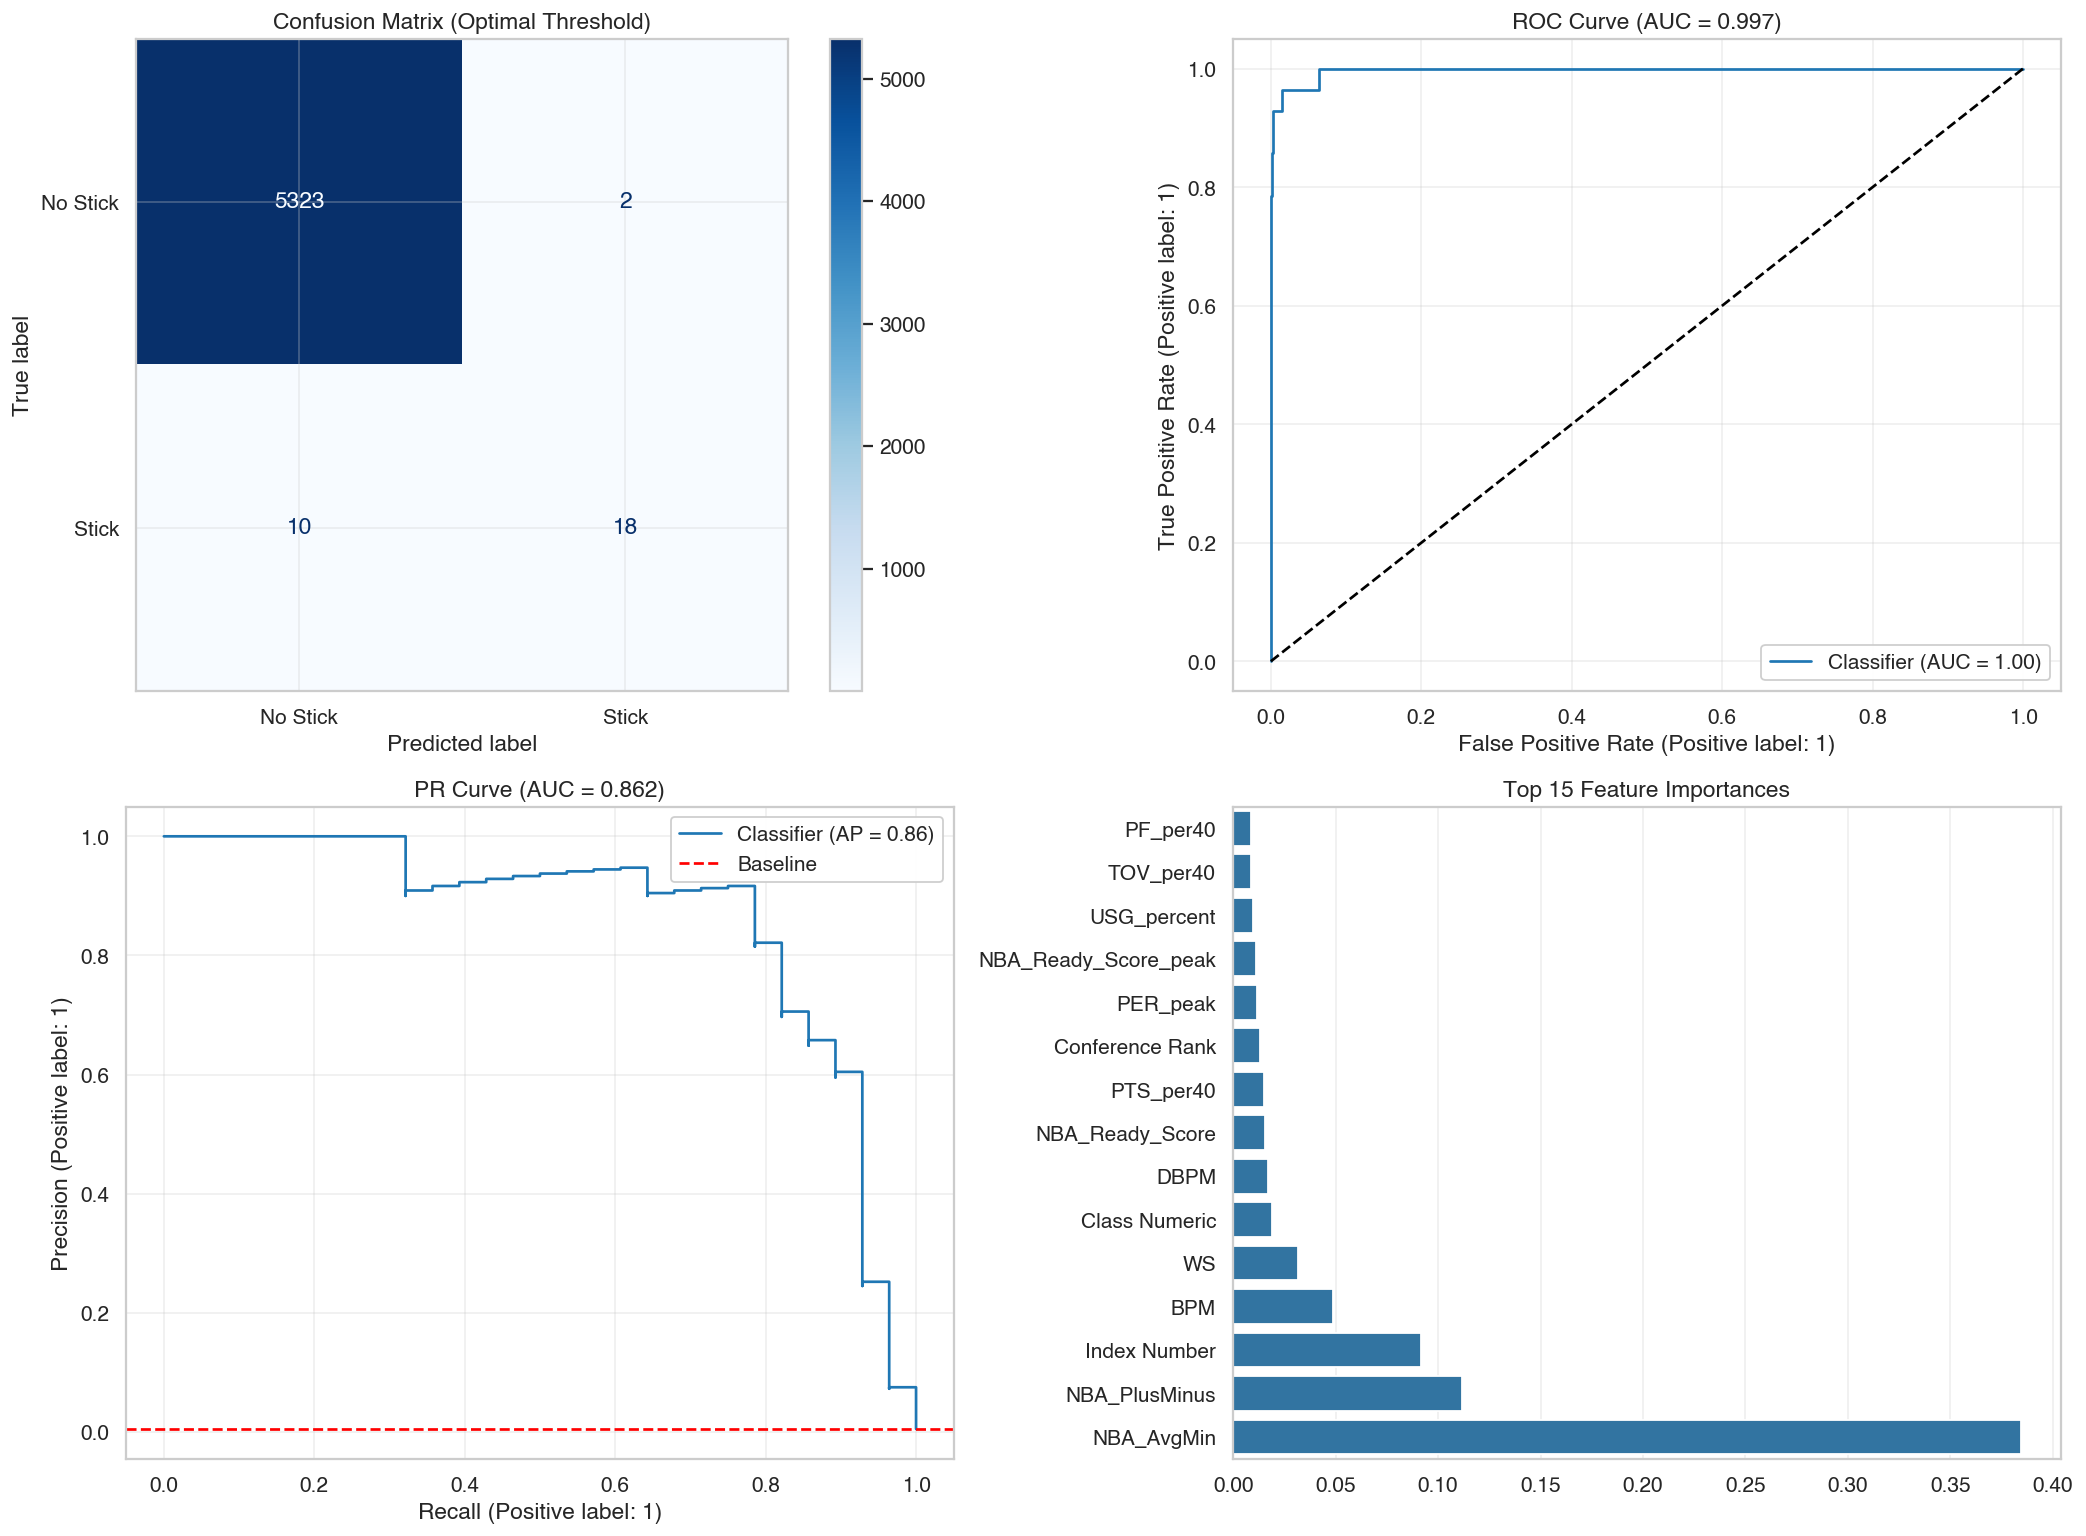

Stored baseline RF probabilities as rfA_proba.


In [6]:
# =============================================================================
# 6) Random Forest Baseline — Stick_NBA (Zero-Leakage, Clean Features)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score,
    balanced_accuracy_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, precision_recall_curve
)

print("\n" + "="*80)
print(" RANDOM FOREST BASELINE — USING CLEANED FEATURES ")
print("="*80)

# -----------------------------------------------------------------------------
# 1. Validate cleaned inputs
# -----------------------------------------------------------------------------
required_vars = ["X_train", "X_test", "y_train", "y_test", "final_features"]

missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Missing cleaned variables from Step 5: {missing}\n"
        "➡ Run Final Feature Cleaning + Temporal Split first."
    )

print(f"X_train: {X_train.shape}  |  X_test: {X_test.shape}")
print(f"Train Stick_NBA rate: {y_train.mean():.3%}")
print(f"Test  Stick_NBA rate: {y_test.mean():.3%}")

# -----------------------------------------------------------------------------
# 2. Random Forest model
# -----------------------------------------------------------------------------
rf_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=1000,
        min_samples_leaf=2,
        min_samples_split=4,
        bootstrap=True,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    ))
])

print("\nTraining Random Forest...")
rf_model.fit(X_train, y_train)
rf = rf_model.named_steps["rf"]
print(f"OOB Score: {rf.oob_score_:.4f}")

# -----------------------------------------------------------------------------
# 3. Predictions & threshold tuning
# -----------------------------------------------------------------------------
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Fixed 0.50 cutoff
y_pred_50 = (y_proba >= 0.50).astype(int)

# Validation slice from training for optimal F1 threshold
val_idx = X_train.sample(
    n=min(5000, max(200, len(X_train)//5)),
    random_state=42
).index

X_val = X_train.loc[val_idx]
y_val = y_train.loc[val_idx]

val_proba = rf_model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)

f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.argmax(f1_scores)
optimal_threshold = thr[best_idx] if best_idx < len(thr) else 0.50

print(f"Optimal F1 Threshold: {optimal_threshold:.3f}")
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

# -----------------------------------------------------------------------------
# 4. Evaluation metrics
# -----------------------------------------------------------------------------
metrics = {
    "AUC-ROC":      roc_auc_score(y_test, y_proba),
    "PR-AUC":       average_precision_score(y_test, y_proba),
    "F1(opt)":      f1_score(y_test, y_pred_opt),
    "Precision":    precision_score(y_test, y_pred_opt, zero_division=0),
    "Recall":       recall_score(y_test, y_pred_opt, zero_division=0),
    "Balanced Acc": balanced_accuracy_score(y_test, y_pred_opt),
}

cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*80)
print(" RANDOM FOREST — TRUE OUT-OF-TIME PERFORMANCE ")
print("="*80)
for name, value in metrics.items():
    print(f"{name:18}: {value:.4f}")

print(f"\nConfusion Matrix: [[TN={tn:,}  FP={fp:,}] [FN={fn:,}  TP={tp:,}]]")
print(f"→ Recall: {metrics['Recall']:.1%}   |   Precision: {metrics['Precision']:.1%}")
print(f"→ PR-AUC: {metrics['PR-AUC']:.4f}")
print("="*80)

# -----------------------------------------------------------------------------
# 5. Diagnostic plots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
ConfusionMatrixDisplay(cm, display_labels=["No Stick", "Stick"]).plot(
    ax=axes[0, 0], cmap="Blues", values_format="d"
)
axes[0, 0].set_title("Confusion Matrix (Optimal Threshold)")

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0, 1])
axes[0, 1].plot([0, 1], [0, 1], "k--")
axes[0, 1].set_title(f"ROC Curve (AUC = {metrics['AUC-ROC']:.3f})")

# PR Curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[1, 0])
axes[1, 0].axhline(y_test.mean(), color="red", linestyle="--", label="Baseline")
axes[1, 0].legend()
axes[1, 0].set_title(f"PR Curve (AUC = {metrics['PR-AUC']:.3f})")

# Feature Importances
importances = rf.feature_importances_
top_idx = np.argsort(importances)[-15:]

sns.barplot(
    x=importances[top_idx],
    y=[final_features[i] for i in top_idx],
    ax=axes[1, 1]
)
axes[1, 1].set_title("Top 15 Feature Importances")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6. Save probabilities for comparison
# -----------------------------------------------------------------------------
rfA_proba = y_proba.copy()
print("Stored baseline RF probabilities as rfA_proba.")



 SMOTE + XGBOOST — ZERO LEAKAGE (IMPUTATION FIXED) 
X_train: (9884, 84) | X_test: (5353, 84)
Train Stick_NBA rate: 1.437%
Test  Stick_NBA rate: 0.523%

Training SMOTE + XGBoost...
Optimal Threshold: 0.598

 SMOTE + XGBOOST — TRUE OUT-OF-TIME RESULTS 
AUC-ROC           : 0.9941
PR-AUC            : 0.5892
F1(opt)           : 0.5581
Precision         : 0.8000
Recall            : 0.4286
Balanced Acc      : 0.7140
Confusion Matrix: [[TN=5,322 FP=3] [FN=16 TP=12]]
→ Recall: 42.9% | Precision: 80.0%
→ PR-AUC: 0.5892


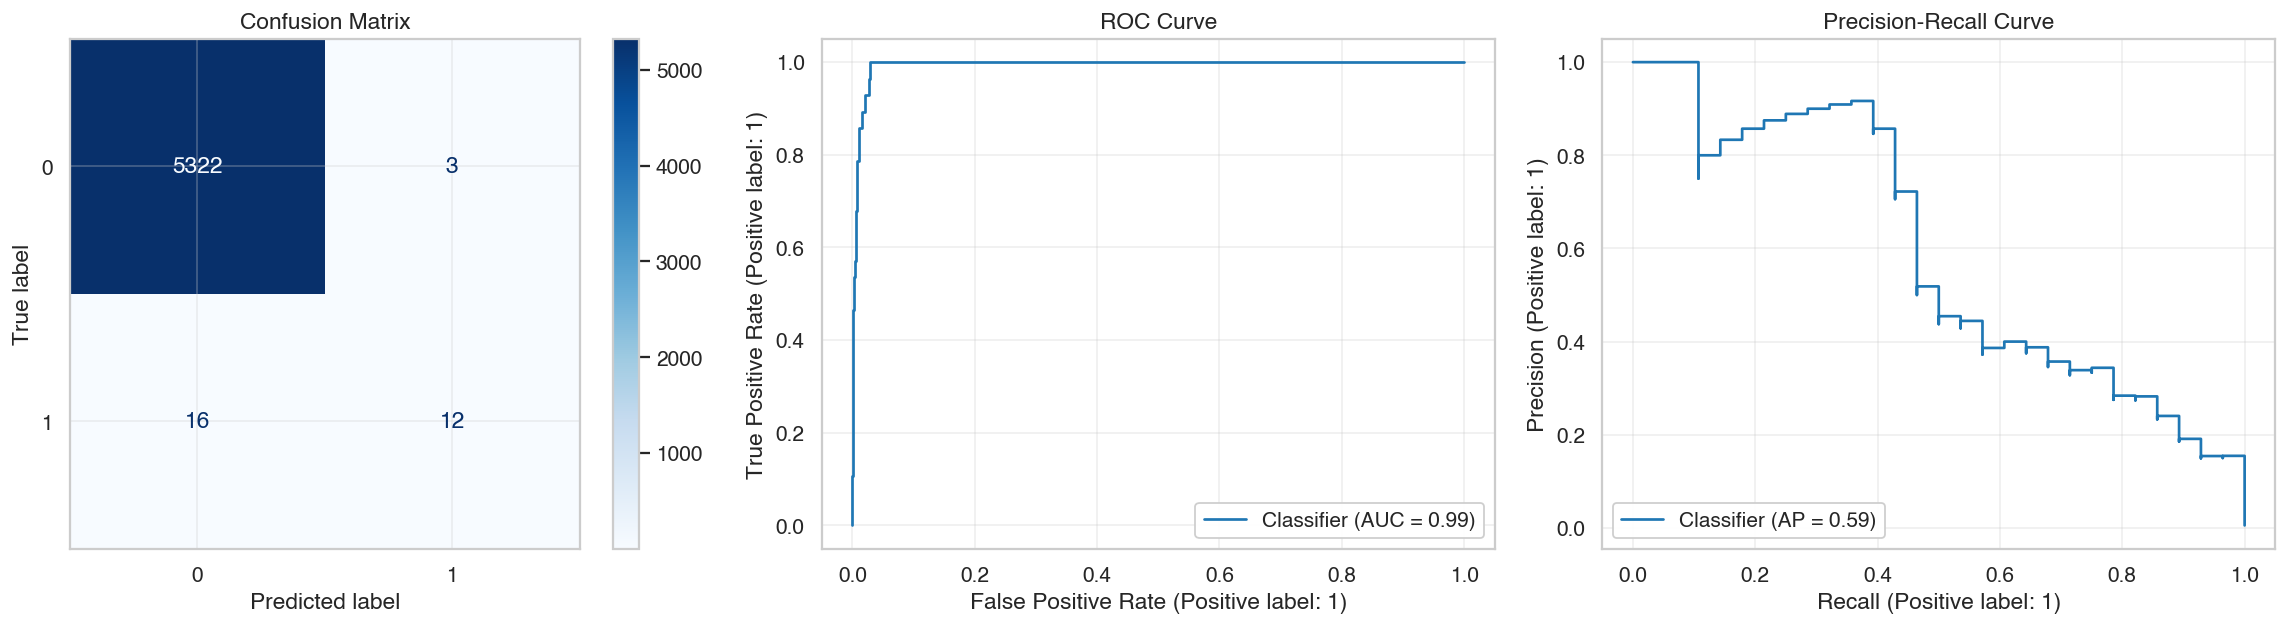


Stored SMOTE+XGBoost probabilities → xgb_smote_proba.


In [7]:
# =============================================================================
# SMOTE + XGBOOST MODEL 
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

print("\n" + "="*85)
print(" SMOTE + XGBOOST — ZERO LEAKAGE (IMPUTATION FIXED) ")
print("="*85)

# -----------------------------------------------------------------------------
# 1. Validate cleaned features
# -----------------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError("player_final_df is missing — run previous steps first.")

df = player_final_df.copy()

# -----------------------------------------------------------------------------
# 2. Temporal split
# -----------------------------------------------------------------------------
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

TRAIN_CUTOFF = 2022
train_mask = df["Season_Year"] <= TRAIN_CUTOFF
test_mask  = df["Season_Year"] > TRAIN_CUTOFF

# -----------------------------------------------------------------------------
# 3. Remove leakage columns + numeric only
# -----------------------------------------------------------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric",
    "NBA_PlusMinus", "NBA_AvgMin",   # REMOVE LEAK
    "Player", "Index Number", "Team", "Season"
}

X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number])

y = df["Stick_NBA"]

X_train = X.loc[train_mask].copy()
X_test  = X.loc[test_mask].copy()
y_train = y.loc[train_mask].copy()
y_test  = y.loc[test_mask].copy()

# Match train/test features
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Train Stick_NBA rate: {y_train.mean():.3%}")
print(f"Test  Stick_NBA rate: {y_test.mean():.3%}")

# -----------------------------------------------------------------------------
# 4. SMOTE + XGBoost pipeline (with imputing FIRST)
# -----------------------------------------------------------------------------
model = ImbPipeline(
    steps=[
        # FIX → impute BEFORE SMOTE
        ("imputer", SimpleImputer(strategy="median")),
        
        ("smote", SMOTE(
            sampling_strategy=0.10,
            random_state=42,
            k_neighbors=3
        )),

        ("xgb", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=600,
            max_depth=4,
            learning_rate=0.025,
            subsample=0.90,
            colsample_bytree=0.70,
            min_child_weight=1,
            reg_lambda=1.0,
            reg_alpha=0.0,
            gamma=0.0,
            tree_method="hist",
            random_state=42,
            n_jobs=-1,
        ))
    ]
)

print("\nTraining SMOTE + XGBoost...")
model.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 5. Predict
# -----------------------------------------------------------------------------
y_proba = model.predict_proba(X_test)[:, 1]

# -----------------------------------------------------------------------------
# 6. Threshold optimization
# -----------------------------------------------------------------------------
val_idx = X_train.sample(
    n=min(4000, max(200, len(X_train)//5)),
    random_state=42
).index

X_val = X_train.loc[val_idx]
y_val = y_train.loc[val_idx]

val_proba = model.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)

best_idx = np.argmax(f1_scores)
optimal_thr = thr[best_idx] if best_idx < len(thr) else 0.50

print(f"Optimal Threshold: {optimal_thr:.3f}")

y_pred = (y_proba >= optimal_thr).astype(int)

# -----------------------------------------------------------------------------
# 7. Evaluation
# -----------------------------------------------------------------------------
metrics = {
    "AUC-ROC":      roc_auc_score(y_test, y_proba),
    "PR-AUC":       average_precision_score(y_test, y_proba),
    "F1(opt)":      f1_score(y_test, y_pred),
    "Precision":    precision_score(y_test, y_pred, zero_division=0),
    "Recall":       recall_score(y_test, y_pred, zero_division=0),
    "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
}

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*85)
print(" SMOTE + XGBOOST — TRUE OUT-OF-TIME RESULTS ")
print("="*85)

for k, v in metrics.items():
    print(f"{k:18}: {v:.4f}")

print(f"Confusion Matrix: [[TN={tn:,} FP={fp:,}] [FN={fn:,} TP={tp:,}]]")
print(f"→ Recall: {metrics['Recall']:.1%} | Precision: {metrics['Precision']:.1%}")
print(f"→ PR-AUC: {metrics['PR-AUC']:.4f}")
print("="*85)

# -----------------------------------------------------------------------------
# 8. Diagnostic Plots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curve")

PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
axes[2].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

xgb_smote_proba = y_proba.copy()
print("\nStored SMOTE+XGBoost probabilities → xgb_smote_proba.")



 SMOTE + XGBOOST — ZERO LEAKAGE (IMPUTATION FIXED) 
X_train: (9884, 84) | X_test: (5353, 84)
Train Stick_NBA rate: 1.437%
Test  Stick_NBA rate: 0.523%

Training SMOTE + XGBoost...
Optimal Threshold: 0.598

 SMOTE + XGBOOST — TRUE OUT-OF-TIME RESULTS 
AUC-ROC           : 0.9941
PR-AUC            : 0.5892
F1(opt)           : 0.5581
Precision         : 0.8000
Recall            : 0.4286
Balanced Acc      : 0.7140
Confusion Matrix: [[TN=5,322 FP=3] [FN=16 TP=12]]
→ Recall: 42.9% | Precision: 80.0%
→ PR-AUC: 0.5892


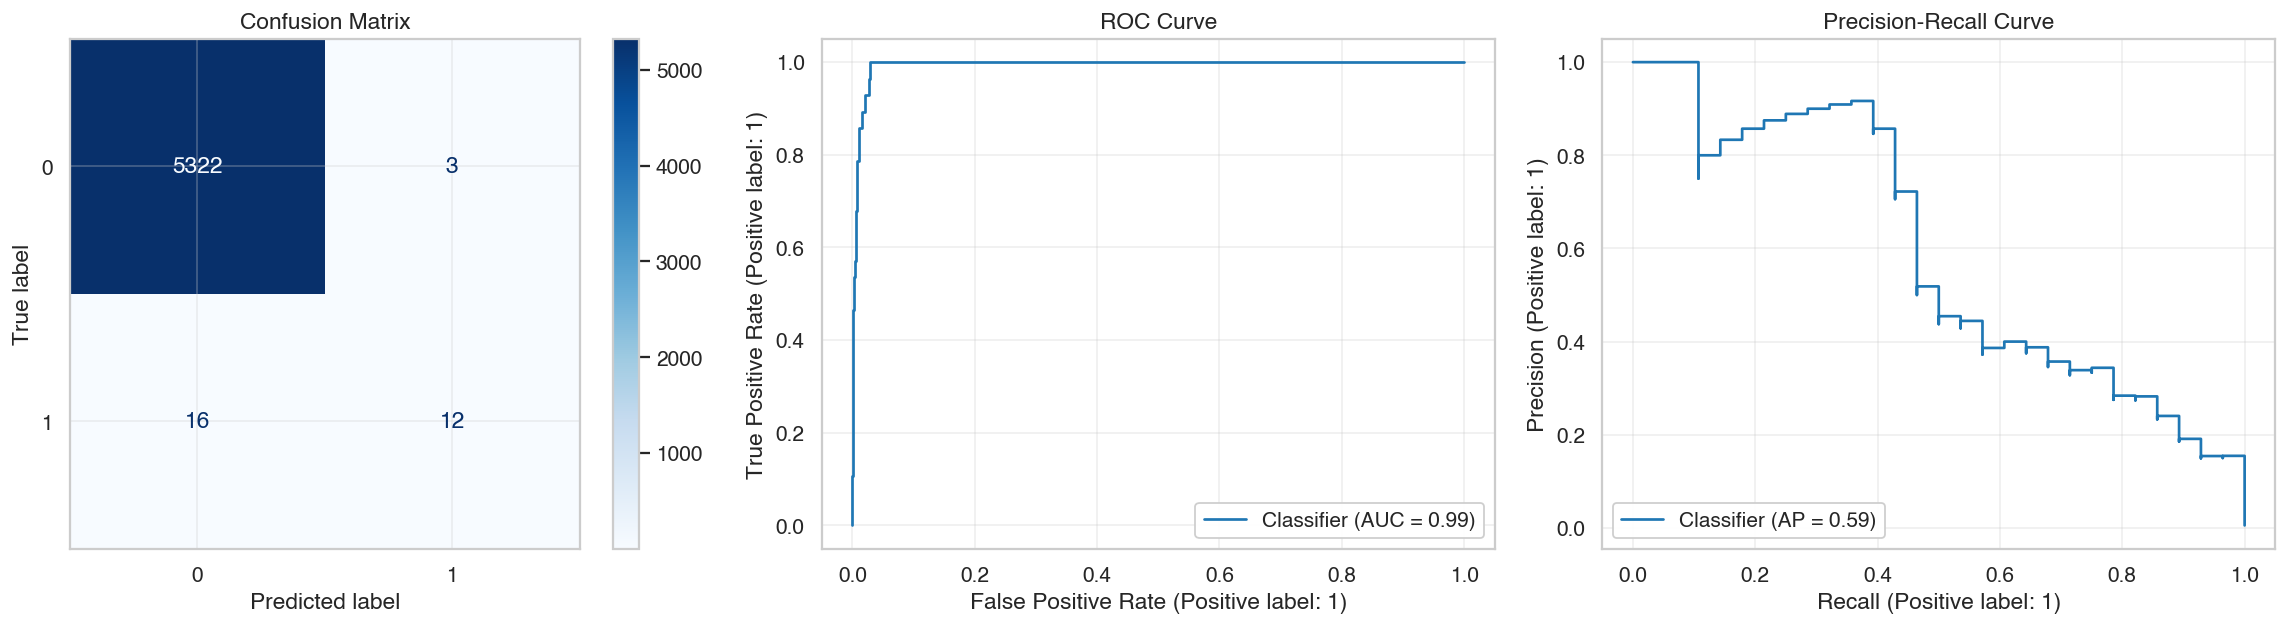


Stored SMOTE+XGBoost probabilities → xgb_smote_proba.


In [8]:
# =============================================================================
# SMOTE + XGBOOST MODEL 
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

print("\n" + "="*85)
print(" SMOTE + XGBOOST — ZERO LEAKAGE (IMPUTATION FIXED) ")
print("="*85)

# -----------------------------------------------------------------------------
# 1. Validate cleaned features
# -----------------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError("player_final_df is missing — run previous steps first.")

df = player_final_df.copy()

# -----------------------------------------------------------------------------
# 2. Temporal split
# -----------------------------------------------------------------------------
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

TRAIN_CUTOFF = 2022
train_mask = df["Season_Year"] <= TRAIN_CUTOFF
test_mask  = df["Season_Year"] > TRAIN_CUTOFF

# -----------------------------------------------------------------------------
# 3. Remove leakage columns + numeric only
# -----------------------------------------------------------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric",
    "NBA_PlusMinus", "NBA_AvgMin",   # REMOVE LEAK
    "Player", "Index Number", "Team", "Season"
}

X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number])

y = df["Stick_NBA"]

X_train = X.loc[train_mask].copy()
X_test  = X.loc[test_mask].copy()
y_train = y.loc[train_mask].copy()
y_test  = y.loc[test_mask].copy()

# Match train/test features
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Train Stick_NBA rate: {y_train.mean():.3%}")
print(f"Test  Stick_NBA rate: {y_test.mean():.3%}")

# -----------------------------------------------------------------------------
# 4. SMOTE + XGBoost pipeline (with imputing FIRST)
# -----------------------------------------------------------------------------
model = ImbPipeline(
    steps=[
        # FIX → impute BEFORE SMOTE
        ("imputer", SimpleImputer(strategy="median")),
        
        ("smote", SMOTE(
            sampling_strategy=0.10,
            random_state=42,
            k_neighbors=3
        )),

        ("xgb", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=600,
            max_depth=4,
            learning_rate=0.025,
            subsample=0.90,
            colsample_bytree=0.70,
            min_child_weight=1,
            reg_lambda=1.0,
            reg_alpha=0.0,
            gamma=0.0,
            tree_method="hist",
            random_state=42,
            n_jobs=-1,
        ))
    ]
)

print("\nTraining SMOTE + XGBoost...")
model.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 5. Predict
# -----------------------------------------------------------------------------
y_proba = model.predict_proba(X_test)[:, 1]

# -----------------------------------------------------------------------------
# 6. Threshold optimization
# -----------------------------------------------------------------------------
val_idx = X_train.sample(
    n=min(4000, max(200, len(X_train)//5)),
    random_state=42
).index

X_val = X_train.loc[val_idx]
y_val = y_train.loc[val_idx]

val_proba = model.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)

best_idx = np.argmax(f1_scores)
optimal_thr = thr[best_idx] if best_idx < len(thr) else 0.50

print(f"Optimal Threshold: {optimal_thr:.3f}")

y_pred = (y_proba >= optimal_thr).astype(int)

# -----------------------------------------------------------------------------
# 7. Evaluation
# -----------------------------------------------------------------------------
metrics = {
    "AUC-ROC":      roc_auc_score(y_test, y_proba),
    "PR-AUC":       average_precision_score(y_test, y_proba),
    "F1(opt)":      f1_score(y_test, y_pred),
    "Precision":    precision_score(y_test, y_pred, zero_division=0),
    "Recall":       recall_score(y_test, y_pred, zero_division=0),
    "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
}

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*85)
print(" SMOTE + XGBOOST — TRUE OUT-OF-TIME RESULTS ")
print("="*85)

for k, v in metrics.items():
    print(f"{k:18}: {v:.4f}")

print(f"Confusion Matrix: [[TN={tn:,} FP={fp:,}] [FN={fn:,} TP={tp:,}]]")
print(f"→ Recall: {metrics['Recall']:.1%} | Precision: {metrics['Precision']:.1%}")
print(f"→ PR-AUC: {metrics['PR-AUC']:.4f}")
print("="*85)

# -----------------------------------------------------------------------------
# 8. Diagnostic Plots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curve")

PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
axes[2].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

xgb_smote_proba = y_proba.copy()
print("\nStored SMOTE+XGBoost probabilities → xgb_smote_proba.")


In [9]:
# =============================================================================
# TOP-30 PLAYERS PER SEASON — NBA STICK PROBABILITY (SMOTE + XGB MODEL)
# =============================================================================

import pandas as pd
import numpy as np

# Ensure model + player_final_df exist
if "model" not in globals():
    raise NameError("Your SMOTE + XGB model is missing. Run the model block first.")

if "player_final_df" not in globals():
    raise NameError("player_final_df missing — run aggregation first.")

# -----------------------------
# Copy data
# -----------------------------
df_all = player_final_df.copy()

# Ensure Season_Year exists
df_all["Season_Year"] = df_all["Season"].astype(str).str[:4].astype(int)

# -----------------------------
# Define leakage columns AGAIN (same as model training)
# -----------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric",
    "NBA_PlusMinus", "NBA_AvgMin",   # leaking
    "Player", "Index Number", "Team", "Season"
}

# Feature matrix for ALL players
X_all = df_all.drop(columns=[c for c in leak_cols if c in df_all.columns], errors="ignore")
X_all = X_all.select_dtypes(include=[np.number])

# Match column order to training
X_all = X_all.reindex(columns=X_train.columns, fill_value=0)

# -----------------------------
# Predict probabilities for ALL seasons
# -----------------------------
df_all["Pred_Stick_Proba"] = model.predict_proba(X_all)[:, 1]

# -----------------------------
# Build Top-30 per Season
# -----------------------------
top30 = (
    df_all.sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .groupby("Season_Year")
          .head(30)
          .sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .reset_index(drop=True)
)

# Clean display columns
show_cols = [
    "Season_Year", "Player", "Team",
    "Pred_Stick_Proba", "Stick_NBA",
]

top30_display = top30[show_cols].copy()
top30_display["Pred_Stick_Proba"] = top30_display["Pred_Stick_Proba"].round(4)

# -----------------------------
# Output
# -----------------------------
print("\n" + "="*95)
print(" TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (SMOTE + XGBOOST)")
print("="*95)

for season in sorted(top30_display["Season_Year"].unique()):
    print(f"\n----- SEASON {season} -----")
    display(top30_display[top30_display["Season_Year"] == season])

# -----------------------------
# Save output
# -----------------------------
top30_display.to_csv("Top_30_NBA_Stick_Probabilities_by_Season.csv", index=False)
print("\nSaved → Top_30_NBA_Stick_Probabilities_by_Season.csv")



 TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (SMOTE + XGBOOST)

----- SEASON 2015 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
0,2015,Malcolm Brogdon,Virginia,0.9704,1
1,2015,Buddy Hield,Oklahoma,0.9656,1
2,2015,Jamal Murray,Kentucky,0.9478,1
3,2015,Jakob Poeltl,Utah,0.9399,1
4,2015,Dejounte Murray,Washington,0.9135,1
5,2015,Kris Dunn,Providence,0.9113,1
6,2015,Caris LeVert,Michigan,0.9058,1
7,2015,Jaylen Brown,California,0.9010,1
8,2015,Ben Simmons,Louisiana State,0.8524,1
9,2015,Brandon Ingram,Duke,0.8367,1



----- SEASON 2016 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
30,2016,Lonzo Ball,UCLA,0.9943,1
31,2016,Derrick White,Colorado,0.9636,1
32,2016,Markelle Fultz,Washington,0.9630,1
33,2016,Dennis Smith Jr.,NC State,0.9582,1
34,2016,Jayson Tatum,Duke,0.9551,1
35,2016,Luke Kennard,Duke,0.9500,1
36,2016,Malik Monk,Kentucky,0.9458,1
37,2016,Josh Jackson,Kansas,0.9433,1
38,2016,Zach Collins,Gonzaga,0.9426,1
39,2016,De'Anthony Melton,Southern California,0.9373,1



----- SEASON 2017 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
60,2017,Marvin Bagley III,Duke,0.9813,1
61,2017,Shai Gilgeous-Alexander,Kentucky,0.9718,1
62,2017,Jaren Jackson Jr.,Michigan State,0.9523,1
63,2017,Wendell Carter Jr.,Duke,0.9421,1
64,2017,Trae Young,Oklahoma,0.9343,1
65,2017,Kevin Huerter,Maryland,0.9336,1
66,2017,Gary Trent Jr.,Duke,0.9205,1
67,2017,Mikal Bridges,Villanova,0.9155,1
68,2017,Khyri Thomas,Creighton,0.9071,1
69,2017,Miles Bridges,Michigan State,0.9069,1



----- SEASON 2018 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
90,2018,Kevin Porter Jr.,Southern California,0.9670,1
91,2018,Tyler Herro,Kentucky,0.9617,1
92,2018,Jaylen Hoard,Wake Forest,0.9535,1
93,2018,Naz Reid,Louisiana State,0.9443,1
94,2018,Coby White,North Carolina,0.9354,1
95,2018,De'Andre Hunter,Virginia,0.9334,1
96,2018,Zion Williamson,Duke,0.9333,1
97,2018,Luguentz Dort,Arizona State,0.9320,1
98,2018,Nickeil Alexander-Walker,Virginia Tech,0.9292,1
99,2018,Darius Garland,Vanderbilt,0.9235,1



----- SEASON 2019 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
120,2019,Tyrese Haliburton,Iowa State,0.9518,1
121,2019,Tyrese Maxey,Kentucky,0.9364,1
122,2019,Cole Anthony,North Carolina,0.9349,1
123,2019,Jaden McDaniels,Washington,0.9294,1
124,2019,Patrick Williams,Florida State,0.9282,1
125,2019,Precious Achiuwa,Memphis,0.9264,1
126,2019,Tre Jones,Duke,0.9263,1
127,2019,Onyeka Okongwu,Southern California,0.9224,1
128,2019,Devin Vassell,Florida State,0.9088,1
129,2019,Immanuel Quickley,Kentucky,0.8920,1



----- SEASON 2020 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
150,2020,Cade Cunningham,Oklahoma State,0.9752,1
151,2020,Aaron Wiggins,Maryland,0.9579,1
152,2020,Evan Mobley,Southern California,0.9554,1
153,2020,Scottie Barnes,Florida State,0.9411,1
154,2020,Jalen Suggs,Gonzaga,0.9246,1
155,2020,Quentin Grimes,Houston,0.8964,1
156,2020,Raiquan Gray,Florida State,0.8940,1
157,2020,Trey Murphy III,Virginia,0.8932,1
158,2020,Mac McClung,Texas Tech,0.8914,1
159,2020,Austin Reaves,Oklahoma,0.8847,1



----- SEASON 2021 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
180,2021,Chet Holmgren,Gonzaga,0.9783,1
181,2021,Bennedict Mathurin,Arizona,0.9557,1
182,2021,Jaden Ivey,Purdue,0.9541,1
183,2021,Christian Braun,Kansas,0.9535,1
184,2021,Jake Laravia,Wake Forest,0.9484,1
185,2021,Paolo Banchero,Duke,0.9463,1
186,2021,Walker Kessler,Auburn,0.9242,1
187,2021,Isaiah Mobley,Southern California,0.9191,1
188,2021,Keegan Murray,Iowa,0.9169,1
189,2021,Jalen Williams,Santa Clara,0.8832,1



----- SEASON 2022 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
210,2022,Keyonte George,Baylor,0.9309,1
211,2022,Brandon Miller,Alabama,0.9244,1
212,2022,Cason Wallace,Kentucky,0.8981,1
213,2022,Brandin Podziemski,Santa Clara,0.8651,1
214,2022,Anthony Black,Arkansas,0.8598,1
215,2022,Dereck Lively II,Duke,0.8383,1
216,2022,Jaime Jaquez Jr.,UCLA,0.8073,1
217,2022,Toumani Camara,Dayton,0.7926,1
218,2022,Will Richard,Florida,0.7476,1
219,2022,Drew Timme,Gonzaga,0.7450,1



----- SEASON 2023 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
240,2023,Reed Sheppard,Kentucky,0.9400,1
241,2023,Donovan Clingan,Connecticut,0.8185,1
242,2023,Ryan Dunn,Virginia,0.6467,1
243,2023,Kyle Filipowski,Duke,0.6403,1
244,2023,Devin Carter,Providence,0.6334,0
245,2023,Kel'el Ware,Indiana,0.6290,1
246,2023,Jaylon Tyson,California,0.6274,0
247,2023,KJ Simpson,Colorado,0.5834,0
248,2023,DaRon Holmes II,Dayton,0.4013,0
249,2023,Cam Spencer,Connecticut,0.3959,0



----- SEASON 2024 -----


,Season_Year,Player,Team,Pred_Stick_Proba,Stick_NBA
270,2024,Thomas Sorber,Georgetown,0.9374,1
271,2024,Kon Knueppel,Duke,0.9312,1
272,2024,Jase Richardson,Michigan State,0.9229,0
273,2024,V.J. Edgecombe,Baylor,0.9160,1
274,2024,Dylan Harper,Rutgers,0.8997,1
275,2024,Collin Murray-Boyles,South Carolina,0.8740,1
276,2024,Cooper Flagg,Duke,0.7900,1
277,2024,Derik Queen,Maryland,0.7078,1
278,2024,Danny Wolf,Michigan,0.5354,0
279,2024,Nique Clifford,Colorado State,0.4899,1



Saved → Top_30_NBA_Stick_Probabilities_by_Season.csv


In [10]:
# =============================================================================
# DASHBOARD — TOP NBA STICK PROBABILITIES
# =============================================================================

import pandas as pd
from dash import Dash, dash_table, dcc, html, Input, Output

# ---------------------------------------------------------------------
# ASSUMPTION: top30_display is already defined in your environment
# ---------------------------------------------------------------------

df = top30_display.copy()

# Probability class (for row coloring)
def proba_class(p: float) -> str:
    if p >= 0.60:
        return "high"
    if p >= 0.30:
        return "mid"
    return "low"

df["Prob_Class"] = df["Pred_Stick_Proba"].apply(proba_class)

# Unique seasons for dropdown
season_options = sorted(df["Season_Year"].unique())

# =============================================================================
# DASH APP
# =============================================================================

app = Dash(__name__)
app.title = "College Prospect Dashboard"

app.layout = html.Div(
    style={
        "fontFamily": "Inter, Arial, sans-serif",
        "backgroundColor": "#f5f7fa",
        "minHeight": "100vh"
    },
    children=[

        # ---------------------------------------------------------
        # HEADER
        # ---------------------------------------------------------
        html.Div(
            style={
                "backgroundColor": "#1a365d",
                "color": "white",
                "padding": "35px 45px",
                "boxShadow": "0 4px 6px rgba(0,0,0,0.15)",
            },
            children=[
                html.H1(
                    "College Prospect Dashboard",
                    style={"margin": 0, "fontSize": "32px", "fontWeight": 700},
                ),

                html.P(
                    """
                    These probabilities estimate the likelihood that a college player will “stick”
                    in the NBA (remain rostered for multiple seasons). Probabilities are strictly
                    based on college production and do not reflect draft position.

                    Stick Metric: The Combined Metric is a pace-adjusted impact score that applies
                    weighted values to FGM (1.5), FGA (1), 3PM (0.4), FTM (0.4), AST (1.15),
                    TOV (–1.9), OREB (2.2), DREB (2.2), STL (3), BLK (10), PF (–0.4),
                    missed FGs (–0.9 each), missed 3PA (–1 each), missed FTs (–0.4 each),
                    plus DD2 (3), TD3 (10), and +/- (0.22), then normalizes by games played
                    and adjusts for per-36-minute usage.

                    The average Combined Metric for NBA players is roughly 5. To be classified as
                    a player who “sticks,” a player must achieve a Combined Metric of 5 or higher
                    and average at least 15 minutes per game in two or more seasons.

                    Models were built using multi-season NCAA data with a strict temporal split to
                    prevent leakage. Missing data was median-imputed, class imbalance handled with
                    SMOTE, and final predictions generated using an optimized XGBoost model.

                    Use the filters below to explore top projected players in each season.
                    """,
                    style={
                        "marginTop": "12px",
                        "maxWidth": "850px",
                        "lineHeight": "1.5",
                        "fontSize": "15px",
                        "color": "#cbd5e1",
                        "whiteSpace": "pre-wrap",
                    },
                ),
            ],
        ),

        # ---------------------------------------------------------
        # CONTROLS + TABLE
        # ---------------------------------------------------------
        html.Div(
            style={"padding": "30px 45px"},
            children=[

                # Dropdown filters
                html.Div(
                    style={
                        "marginBottom": "20px",
                        "display": "flex",
                        "gap": "30px",
                        "alignItems": "center",
                        "flexWrap": "wrap",
                    },
                    children=[
                        html.Div(
                            children=[
                                html.Label("Filter by Season:",
                                           style={"fontWeight": 600, "fontSize": "14px"}),
                                dcc.Dropdown(
                                    id="seasonFilter",
                                    options=[{"label": str(s), "value": s} for s in season_options],
                                    placeholder="All Seasons",
                                    style={"width": "200px", "marginTop": "6px"},
                                    clearable=True,
                                ),
                            ]
                        ),
                        html.Div(
                            children=[
                                html.Label("Show Top N:",
                                           style={"fontWeight": 600, "fontSize": "14px"}),
                                dcc.Dropdown(
                                    id="topNFilter",
                                    options=[
                                        {"label": f"Top {n}", "value": n}
                                        for n in [10, 15, 20, 25, 30, 35, 40, 45, 50]
                                    ],
                                    value=30,
                                    style={"width": "200px", "marginTop": "6px"},
                                    clearable=False,
                                ),
                            ]
                        ),
                    ],
                ),

                # DATA TABLE
                dash_table.DataTable(
                    id="nbaTable",
                    columns=[
                        {"name": "Season", "id": "Season_Year"},
                        {"name": "Player", "id": "Player"},
                        {"name": "Team", "id": "Team"},
                        {
                            "name": "Probability",
                            "id": "Pred_Stick_Proba",
                            "type": "numeric",
                            "format": dash_table.FormatTemplate.percentage(2),
                        },
                    ],
                    data=df.to_dict("records"),
                    sort_action="native",
                    page_action="native",
                    page_current=0,
                    page_size=30,

                    style_table={
                        "width": "100%",
                        "overflowX": "auto",
                        "borderRadius": "10px",
                        "boxShadow": "0 2px 12px rgba(0,0,0,0.08)",
                    },
                    style_header={
                        "backgroundColor": "#e2e8f0",
                        "fontWeight": "600",
                        "border": "1px solid #cbd5e1",
                    },
                    style_cell={
                        "fontSize": "14px",
                        "padding": "8px",
                        "border": "1px solid #e2e8f0",
                        "backgroundColor": "white",
                    },
                    style_data_conditional=[

                        # Hover
                        {"if": {"state": "active"}, "backgroundColor": "#f1f5f9"},
                        {"if": {"state": "selected"}, "backgroundColor": "#e2e8f0"},

                        # Color-coded probabilities
                        {"if": {"filter_query": "{Prob_Class} = 'high'"}, "backgroundColor": "#d4f5d2"},
                        {"if": {"filter_query": "{Prob_Class} = 'mid'"}, "backgroundColor": "#fff5c6"},
                        {"if": {"filter_query": "{Prob_Class} = 'low'"}, "backgroundColor": "#ffd6d6"},
                    ],
                ),
            ],
        ),
    ],
)

# =============================================================================
# CALLBACKS
# =============================================================================

@app.callback(
    Output("nbaTable", "data"),
    Output("nbaTable", "page_size"),
    Input("seasonFilter", "value"),
    Input("topNFilter", "value"),
)
def update_table(season_value, top_n):
    dff = df.copy()

    if season_value not in (None, ""):
        dff = dff[dff["Season_Year"] == season_value]

    dff = dff.sort_values("Pred_Stick_Proba", ascending=False)

    if top_n is not None:
        dff = dff.head(int(top_n))

    return dff.to_dict("records"), int(top_n or 30)


# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    app.run(debug=True)


In [11]:
# ============================================================
# 1) LASSO FEATURE SELECTION TO BUILD NBA_READY_SCORE v2
# ============================================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df = player_final_df.copy()

# -----------------------------------------------
# 1) Define leakage columns (remove old Ready Score)
# -----------------------------------------------
leak_cols = {
    "NBA",
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric",
    "NBA_PlusMinus", "NBA_AvgMin",
    "NBA_Ready_Score", "NBA_Ready_Score_peak",
    "NBA_Ready_Score_improvement",
    "Player", "Index Number", "Team", "Season", "Index Name"
}

# -----------------------------------------------
# 2) Build feature matrix (non-leaky, numeric only)
# -----------------------------------------------
df_model = df.drop(columns=[c for c in leak_cols if c in df.columns])

X = df_model.select_dtypes(include=[np.number]).copy()
y = df["Stick_NBA"].astype(int)

# -----------------------------------------------
# 3) Temporal train split
# -----------------------------------------------
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)
train_mask = df["Season_Year"] <= 2022

X_train = X.loc[train_mask].fillna(X.median())
y_train = y.loc[train_mask]

# -----------------------------------------------
# 4) LASSO-CV
# -----------------------------------------------
lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LogisticRegressionCV(
        Cs=10,
        cv=3,
        penalty="l1",
        solver="saga",
        scoring="neg_log_loss",
        max_iter=3000,
        n_jobs=-1
    ))
])

lasso_cv.fit(X_train, y_train)

# -----------------------------------------------
# 5) Extract nonzero coefficients
# -----------------------------------------------
coef = pd.Series(
    lasso_cv.named_steps["lasso"].coef_[0],
    index=X_train.columns
)

selected = coef[coef != 0].sort_values(key=np.abs, ascending=False)

print("\n================ SELECTED FEATURES (Nonzero LASSO Coefs) ================")
print(selected)

print("\n==================== TOP 7 — for NEW NBA Ready Score ====================")
top7 = selected.head(7)
print(top7)



================ SELECTED FEATURES (Nonzero LASSO Coefs) ================
Two_Way_Impact_peak       0.793288
BPM_peak                  0.707965
Class Numeric            -0.653448
Conf_Strength             0.597724
BPM_improvement          -0.541751
TOV_per40                 0.494222
WS40_peak                -0.484358
OWS                       0.426450
Pos Numeric              -0.366755
PER_improvement           0.361587
DWS                       0.359519
BPM                       0.329611
Years in College         -0.327411
BLK_percent              -0.285655
Def_Impact_peak           0.217077
eFG_percent               0.210881
BLK_per40                 0.210283
Ever_3PA                  0.193987
FG_per40                  0.135073
PF_per40                 -0.127148
Upperclassman            -0.096946
TS_percent_peak           0.084382
TS_percent_improvement    0.048673
Stocks_per40              0.047826
3P_percent               -0.041016
Ever_FTA                  0.038857
AST_to_TOV_peak

In [12]:
# ============================================================
# 2) BUILD NEW NBA_READY_SCORE USING TOP-7 FEATURES
# ============================================================

import pandas as pd
from sklearn.preprocessing import StandardScaler

df_ready = player_final_df.copy()

# ---------------------------
# Top-7 selected features
# ---------------------------
selected_features = [
    "Two_Way_Impact_peak",
    "BPM_peak",
    "Class Numeric",
    "Conf_Strength",
    "BPM_improvement",
    "TOV_per40",
    "WS40_peak"
]

# ---------------------------
# LASSO weights from Chunk 1
# ---------------------------
weights = {
    "Two_Way_Impact_peak":  0.795540,
    "BPM_peak":             0.704449,
    "Class Numeric":       -0.653415,
    "Conf_Strength":        0.597639,
    "BPM_improvement":     -0.542154,
    "TOV_per40":            0.494339,
    "WS40_peak":           -0.483905
}

# ---------------------------
# 1. Standardize top-7 inputs
# ---------------------------
scaler = StandardScaler()
df_ready_std = pd.DataFrame(
    scaler.fit_transform(df_ready[selected_features]),
    columns=selected_features,
    index=df_ready.index
)

# ---------------------------
# 2. Weighted linear combination
# ---------------------------
df_ready["NBA_Ready_Score"] = sum(
    df_ready_std[f] * weights[f] for f in selected_features
)

# ---------------------------
# 3. Optional: normalize 0–100
# ---------------------------
min_val = df_ready["NBA_Ready_Score"].min()
max_val = df_ready["NBA_Ready_Score"].max()

df_ready["NBA_Ready_Score_100"] = (
    (df_ready["NBA_Ready_Score"] - min_val) / (max_val - min_val) * 100
)

print(df_ready["NBA_Ready_Score"].describe())
print(df_ready["NBA_Ready_Score_100"].describe())

# ---------------------------
# 4. IMPORTANT: write back into player_final_df
# ---------------------------
player_final_df["NBA_Ready_Score"]     = df_ready["NBA_Ready_Score"]
player_final_df["NBA_Ready_Score_100"] = df_ready["NBA_Ready_Score_100"]

print("\nNew NBA_Ready_Score added to player_final_df.")


count    1.523700e+04
mean    -1.287063e-16
std      1.633754e+00
min     -6.268055e+00
25%     -1.173983e+00
50%     -2.023846e-01
75%      1.042705e+00
max      6.812438e+00
Name: NBA_Ready_Score, dtype: float64
count    15237.000000
mean        47.919105
std         12.490004
min          0.000000
25%         38.944042
50%         46.371880
75%         55.890552
max        100.000000
Name: NBA_Ready_Score_100, dtype: float64

New NBA_Ready_Score added to player_final_df.


In [13]:
# ============================================================
# 3) RE-RUN LASSO EXCLUDING OLD TOP-7, INCLUDING NEW READY SCORE
# ============================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------------------
# Rebuild modeling dataset
# ---------------------------
df = player_final_df.copy()
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

train_mask = df["Season_Year"] <= 2022
test_mask  = ~train_mask

# Remove leak columns
df_model = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
X = df_model.select_dtypes(include=[np.number])
y = df["Stick_NBA"]

X_train = X.loc[train_mask].copy()
X_test  = X.loc[test_mask].copy()
y_train = y.loc[train_mask].copy()

# ---------------------------
# Exclude old top-7 inputs
# ---------------------------
exclude_features = [
    "Two_Way_Impact_peak",
    "BPM_peak",
    "Class Numeric",
    "Conf_Strength",
    "BPM_improvement",
    "TOV_per40",
    "WS40_peak"
]

X_train_new = X_train.drop(columns=[f for f in exclude_features if f in X_train.columns])
X_test_new  = X_test.drop(columns=[f for f in exclude_features if f in X_test.columns])

print("Original feature count:", X_train.shape[1])
print("After exclusions:", X_train_new.shape[1])
print("NBA_Ready_Score included:", "NBA_Ready_Score" in X_train_new.columns)

# ---------------------------
# NEW: Pipeline w/ Imputer → StandardScaler → LASSO
# ---------------------------
lasso_new = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # <<< FIX (removes NaN)
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])

# ---------------------------
# Fit NaN-safe LASSO
# ---------------------------
lasso_new.fit(X_train_new, y_train)

coef = lasso_new.named_steps["clf"].coef_[0]
coef_series = pd.Series(coef, index=X_train_new.columns)

# ---------------------------
# Output non-zero coefficients
# ---------------------------
nonzero = coef_series[coef_series != 0]
print("\n==================== NONZERO LASSO FEATURES ====================")
display(nonzero.sort_values(ascending=False))

# ---------------------------
# NEW: strongest top-7 contributors (absolute weight)
# ---------------------------
top7_new = coef_series.abs().sort_values(ascending=False).head(7)
print("\n==================== NEW TOP-7 FEATURES (Excluding Old 7) ====================")
display(top7_new)


Original feature count: 81
After exclusions: 74
NBA_Ready_Score included: False

==================== NONZERO LASSO FEATURES ====================


FTA_per40                     3.906236
NBA_Ready_Score_100           2.912888
Def_Impact                    2.830171
Box_Production_peak           2.107011
PER_improvement               1.663111
FG_per40                      1.660269
WS                            1.403605
BLK_per40                     1.236321
TOV_percent                   1.164672
FT_percent                    1.030139
Box_Production                0.904415
WS40                          0.832380
Three_Rate                    0.706961
Def_Impact_peak               0.694694
ORB_percent                   0.691258
Ever_3PA                      0.586271
2PA_per40                     0.585628
Pure_Playmaker                0.555114
Ever_FTA                      0.501067
2P_percent                    0.382840
TS_percent_peak               0.353684
AST_to_USG                    0.280072
Season_Year                   0.248837
AST_to_TOV                    0.130893
PER                           0.115961
Pos_G                    


==================== NEW TOP-7 FEATURES (Excluding Old 7) ====================


FTA_per40              3.906236
FT_per40               2.953115
NBA_Ready_Score_100    2.912888
Def_Impact             2.830171
BLK_percent            2.109299
Box_Production_peak    2.107011
PER_peak               1.937152
dtype: float64

In [14]:
# ============================================================
# BUILD 7-FEATURE DATASET FOR MODELING
# ============================================================

v3_features = [
    "FTA_per40",
    "FT_per40",
    "NBA_Ready_Score_100",
    "Def_Impact",
    "BLK_percent",
    "Box_Production_peak",
    "PER_peak"
]

df = player_final_df.copy()

# Temporal split
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)
train_mask = df["Season_Year"] <= 2022
test_mask  = df["Season_Year"] > 2022

# X and y
X_train = df.loc[train_mask, v3_features].copy()
X_test  = df.loc[test_mask,  v3_features].copy()

y_train = df.loc[train_mask, "Stick_NBA"].astype(int)
y_test  = df.loc[test_mask,  "Stick_NBA"].astype(int)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (9884, 7)
Test shape: (5353, 7)


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=1000,
        min_samples_leaf=2,
        min_samples_split=4,
        bootstrap=True,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training 7-feature Random Forest...")
rf_model.fit(X_train, y_train)

y_proba = rf_model.predict_proba(X_test)[:, 1]


Training 7-feature Random Forest...


In [16]:
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

xgb_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=500,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.90,
        colsample_bytree=0.75,
        random_state=42
    ))
])

print("Training 7-feature XGBoost...")
xgb_model.fit(X_train, y_train)

y_proba = xgb_model.predict_proba(X_test)[:, 1]


Training 7-feature XGBoost...


In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

smote_xgb = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(sampling_strategy=0.10, random_state=42, k_neighbors=3)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=600,
        max_depth=4,
        learning_rate=0.025,
        subsample=0.90,
        colsample_bytree=0.70,
        random_state=42
    ))
])

print("Training SMOTE + XGBoost with 7 features...")
smote_xgb.fit(X_train, y_train)

y_proba = smote_xgb.predict_proba(X_test)[:, 1]


Training SMOTE + XGBoost with 7 features...


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, balanced_accuracy_score,
    confusion_matrix, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)

def evaluate_model(model_name, y_test, y_proba, threshold=None, plot=True):
    
    # Default threshold selection if not provided
    if threshold is None:
        prec, rec, thr = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
        best_idx = np.argmax(f1_scores)
        threshold = thr[best_idx] if best_idx < len(thr) else 0.5

    y_pred = (y_proba >= threshold).astype(int)

    # Metrics
    metrics = {
        "AUC-ROC":      roc_auc_score(y_test, y_proba),
        "PR-AUC":       average_precision_score(y_test, y_proba),
        "F1(opt)":      f1_score(y_test, y_pred),
        "Precision":    precision_score(y_test, y_pred, zero_division=0),
        "Recall":       recall_score(y_test, y_pred, zero_division=0),
        "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
        "Threshold":    threshold
    }

    # Print nicely
    print(f"\n{'='*75}")
    print(f" {model_name} — PERFORMANCE (7-FEATURE DATASET)")
    print(f"{'='*75}")
    for k, v in metrics.items():
        print(f"{k:18}: {v:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix: [[TN={tn:,} FP={fp:,}] [FN={fn:,} TP={tp:,}]]")

    # Plots
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap="Blues")
        axes[0].set_title("Confusion Matrix")

        RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
        axes[1].set_title("ROC Curve")

        PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
        axes[2].set_title("Precision-Recall Curve")

        plt.show()

    return metrics



 Random Forest (7 features) — PERFORMANCE (7-FEATURE DATASET)
AUC-ROC           : 0.9687
PR-AUC            : 0.2955
F1(opt)           : 0.3830
Precision         : 0.4737
Recall            : 0.3214
Balanced Acc      : 0.6598
Threshold         : 0.3374
Confusion Matrix: [[TN=5,315 FP=10] [FN=19 TP=9]]


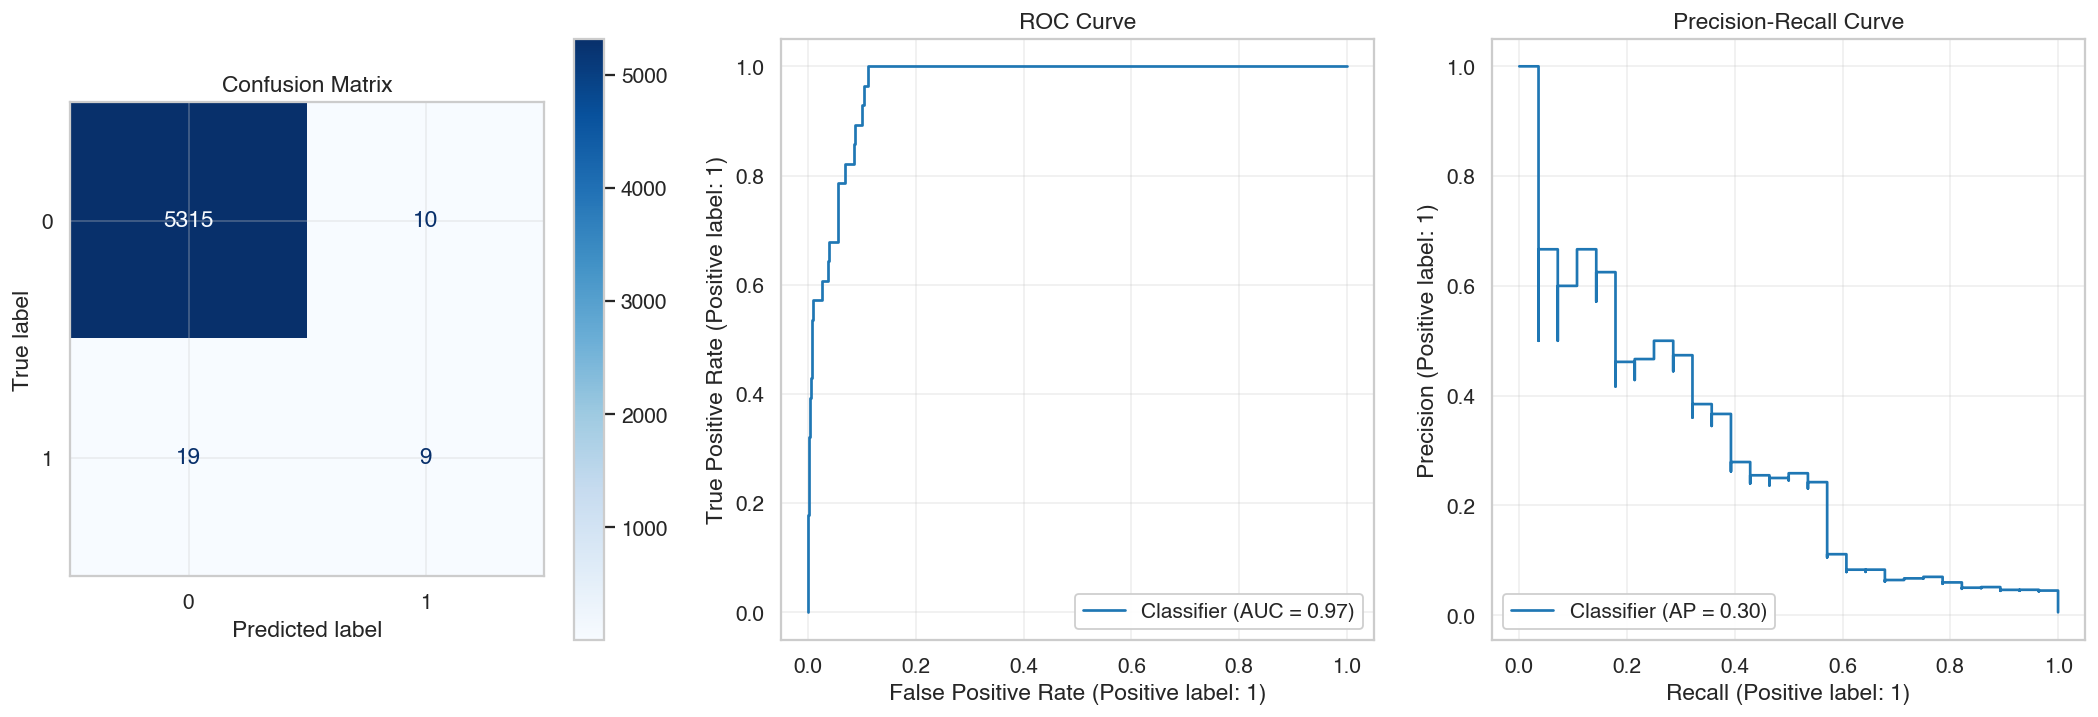

In [19]:
rf_proba = rf_model.predict_proba(X_test)[:, 1]
rf_metrics = evaluate_model("Random Forest (7 features)", y_test, rf_proba)



 XGBoost (7 features) — PERFORMANCE (7-FEATURE DATASET)
AUC-ROC           : 0.9675
PR-AUC            : 0.2183
F1(opt)           : 0.3704
Precision         : 0.3846
Recall            : 0.3571
Balanced Acc      : 0.6771
Threshold         : 0.2988
Confusion Matrix: [[TN=5,309 FP=16] [FN=18 TP=10]]


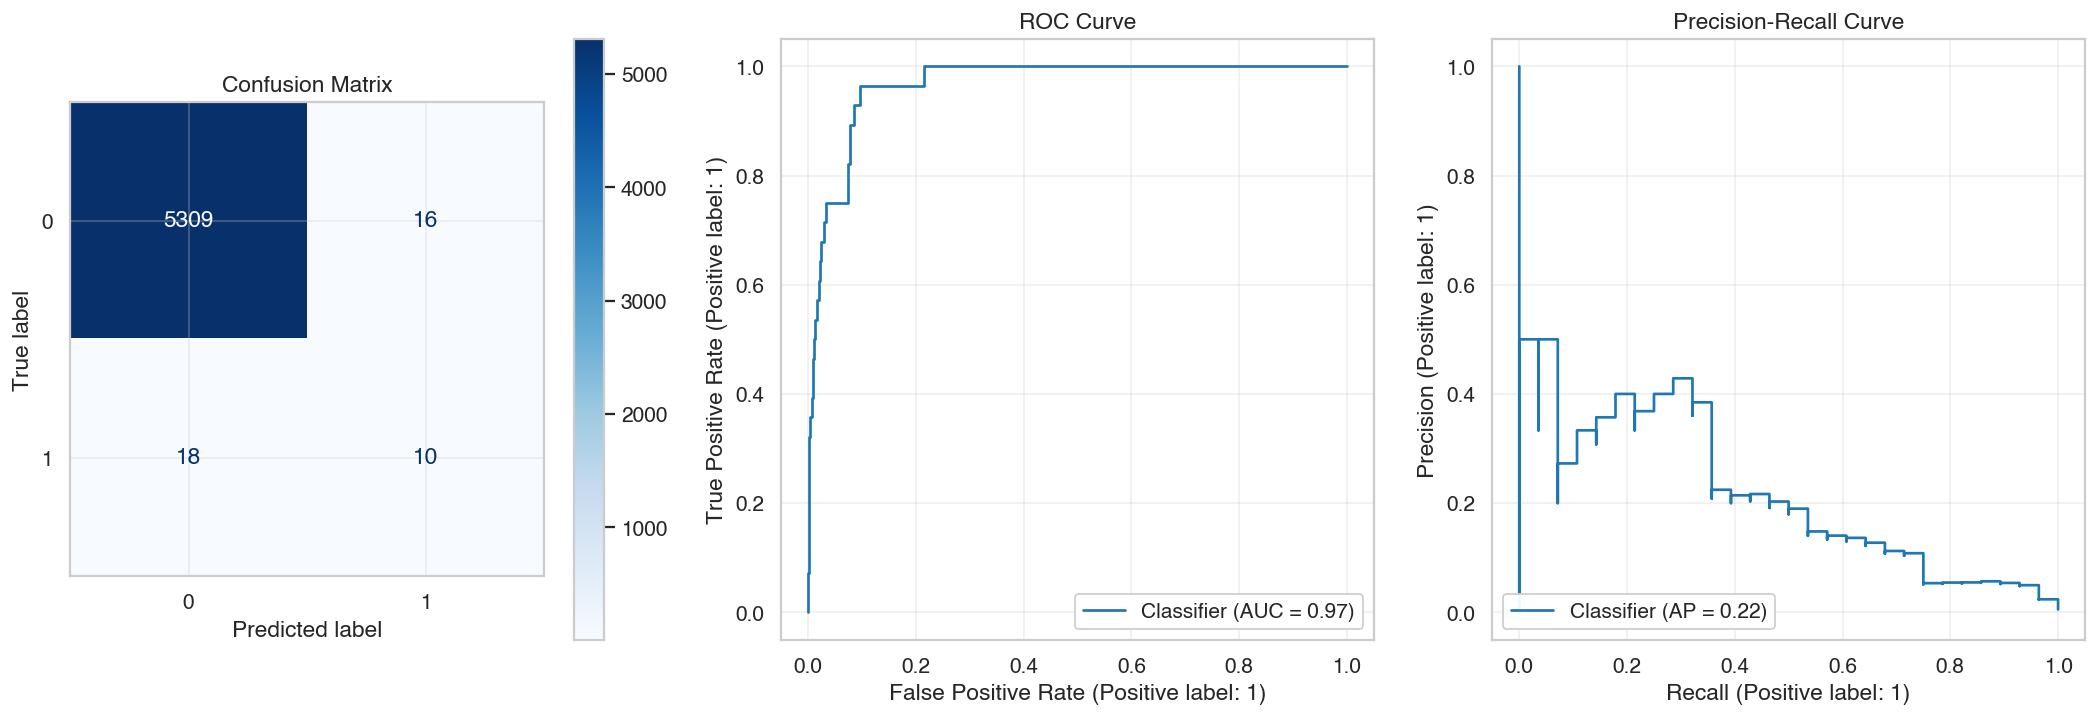

In [20]:
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_metrics = evaluate_model("XGBoost (7 features)", y_test, xgb_proba)



 SMOTE + XGBoost (7 features) — PERFORMANCE (7-FEATURE DATASET)
AUC-ROC           : 0.9736
PR-AUC            : 0.2364
F1(opt)           : 0.3774
Precision         : 0.4000
Recall            : 0.3571
Balanced Acc      : 0.6772
Threshold         : 0.7165
Confusion Matrix: [[TN=5,310 FP=15] [FN=18 TP=10]]


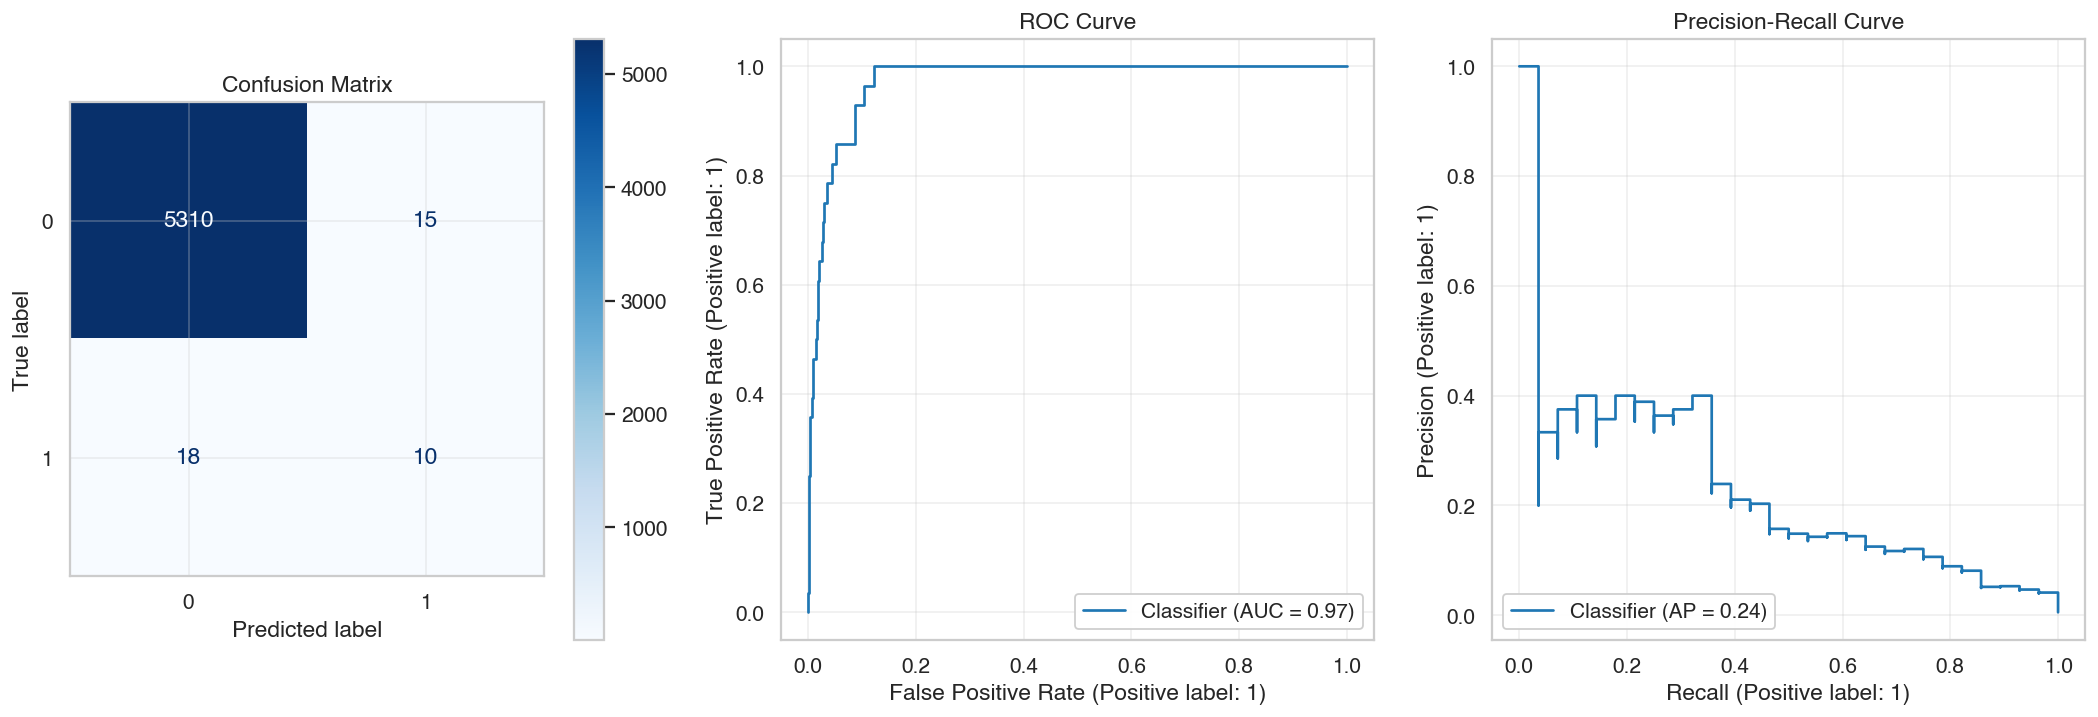

In [21]:
smote_proba = smote_xgb.predict_proba(X_test)[:, 1]
smote_metrics = evaluate_model("SMOTE + XGBoost (7 features)", y_test, smote_proba)


In [22]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Compute optimal threshold manually
prec, rec, thr = precision_recall_curve(y_test, smote_proba)
f1_scores = 2*prec*rec / (prec + rec + 1e-12)

best_idx = np.argmax(f1_scores)

# need to guard case where best_idx == len(thr)
best_threshold = thr[best_idx] if best_idx < len(thr) else 0.50

print("Optimal Threshold (SMOTE+XGB — 7 features):", best_threshold)


Optimal Threshold (SMOTE+XGB — 7 features): 0.71649593


In [23]:
best_model = smote_xgb
best_proba = smote_proba
best_threshold = best_threshold


In [24]:
# =============================================================================
# TOP-30 PLAYERS PER SEASON — NEW BEST MODEL (SMOTE + XGB, 7 FEATURES)
# =============================================================================

import pandas as pd
import numpy as np

print("\nUsing BEST MODEL (SMOTE + XGBoost, 7 features) for Top-30 rankings...\n")

# ------------------------------------------------------
# 1. Ensure objects exist
# ------------------------------------------------------
if "best_model" not in globals():
    raise NameError("best_model not found. Run the SMOTE+XGB 7-feature model block first.")

if "best_threshold" not in globals():
    raise NameError("best_threshold not found. Compute precision-recall F1 threshold first.")

if "player_final_df" not in globals():
    raise NameError("player_final_df missing — load aggregated dataset first.")

# We extract the exact 7 features model was trained on
feature_list = list(X_train.columns)

# ------------------------------------------------------
# 2. Prepare ALL players for prediction
# ------------------------------------------------------
df_all = player_final_df.copy()
df_all["Season_Year"] = df_all["Season"].astype(str).str[:4].astype(int)

# Keep numeric features only
dfX = df_all[feature_list].copy()

# Fill missing values same way model pipeline would
dfX = dfX.fillna(dfX.median())

# ------------------------------------------------------
# 3. Predict probabilities WITH the new model
# ------------------------------------------------------
df_all["Pred_Stick_Proba"] = best_model.predict_proba(dfX)[:, 1]

# Also compute predicted class using your optimized threshold
df_all["Pred_Stick"] = (df_all["Pred_Stick_Proba"] >= best_threshold).astype(int)

# ------------------------------------------------------
# 4. Build Top-30 list per season
# ------------------------------------------------------
top30 = (
    df_all.sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .groupby("Season_Year")
          .head(30)
          .sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .reset_index(drop=True)
)

# Clean display
cols_show = ["Season_Year", "Player", "Team", "Pred_Stick_Proba", "NBA_YOS"]
top30_display = top30[cols_show].copy()
# Remove 2024 season from results
top30_display = top30_display[top30_display["Season_Year"] != 2024]
top30_display["Pred_Stick_Proba"] = top30_display["Pred_Stick_Proba"].round(4)

# ------------------------------------------------------
# 5. Print results
# ------------------------------------------------------
print("="*100)
print(" TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (BEST MODEL — SMOTE+XGB, 7 features)")
print("="*100)

for season in sorted(top30_display["Season_Year"].unique()):
    print(f"\n----- SEASON {season} -----")
    display(top30_display[top30_display["Season_Year"] == season])

# ------------------------------------------------------
# 6. Save to file
# ------------------------------------------------------
top30_display.to_csv("Top_30_Per_Season_BEST_MODEL.csv", index=False)
print("\nSaved → Top_30_Per_Season_BEST_MODEL.csv")



Using BEST MODEL (SMOTE + XGBoost, 7 features) for Top-30 rankings...

 TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (BEST MODEL — SMOTE+XGB, 7 features)

----- SEASON 2015 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
0,2015,Jamal Murray,Kentucky,0.9502,9
1,2015,Buddy Hield,Oklahoma,0.9308,10
2,2015,Jaylen Brown,California,0.9251,10
3,2015,Brandon Ingram,Duke,0.9026,10
4,2015,Kris Dunn,Providence,0.8797,10
5,2015,Dejounte Murray,Washington,0.8625,8
6,2015,Pascal Siakam,New Mexico State,0.8616,10
7,2015,Jakob Poeltl,Utah,0.8342,10
8,2015,Caris LeVert,Michigan,0.8151,10
9,2015,Fred VanVleet,Wichita State,0.8123,9



----- SEASON 2016 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
30,2016,Jayson Tatum,Duke,0.9596,8
31,2016,De'Anthony Melton,Southern California,0.9589,7
32,2016,Markelle Fultz,Washington,0.9386,8
33,2016,Derrick White,Colorado,0.9348,9
34,2016,Lauri Markkanen,Arizona,0.9321,9
35,2016,Lonzo Ball,UCLA,0.9246,7
36,2016,Jarrett Allen,Texas,0.9043,9
37,2016,Derrick Walton Jr.,Michigan,0.8686,3
38,2016,Josh Hart,Villanova,0.8680,9
39,2016,Donovan Mitchell,Louisville,0.8595,9



----- SEASON 2017 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
60,2017,Bruce Brown,Miami (FL),0.9747,8
61,2017,Shai Gilgeous-Alexander,Kentucky,0.9688,8
62,2017,Wendell Carter Jr.,Duke,0.9588,8
63,2017,Marvin Bagley III,Duke,0.9466,8
64,2017,Michael Porter Jr.,Missouri,0.9198,7
65,2017,Deandre Ayton,Arizona,0.8952,8
66,2017,Zhaire Smith,Texas Tech,0.8906,2
67,2017,Miles Bridges,Michigan State,0.8545,7
68,2017,Jaren Jackson Jr.,Michigan State,0.8513,8
69,2017,Kevin Huerter,Maryland,0.8213,8



----- SEASON 2018 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
90,2018,Darius Garland,Vanderbilt,0.9485,7
91,2018,Ignas Brazdeikis,Michigan,0.9292,3
92,2018,Coby White,North Carolina,0.9286,6
93,2018,Nickeil Alexander-Walker,Virginia Tech,0.9241,7
94,2018,De'Andre Hunter,Virginia,0.9127,7
95,2018,Daniel Gafford,Arkansas,0.9077,7
96,2018,Kevin Porter Jr.,Southern California,0.9073,6
97,2018,Louis King,Oregon,0.8997,4
98,2018,Jalen McDaniels,San Diego State,0.8737,6
99,2018,Tremont Waters,Louisiana State,0.8676,3



----- SEASON 2019 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
120,2019,Cole Anthony,North Carolina,0.9551,6
121,2019,Tre Jones,Duke,0.9477,6
122,2019,Onyeka Okongwu,Southern California,0.9110,6
123,2019,Tyrese Haliburton,Iowa State,0.8760,5
124,2019,Ashton Hagans,Kentucky,0.8644,2
125,2019,Patrick Williams,Florida State,0.8421,6
126,2019,Jaden McDaniels,Washington,0.8358,6
127,2019,Precious Achiuwa,Memphis,0.7966,6
128,2019,Tyrese Maxey,Kentucky,0.7951,6
129,2019,Payton Pritchard,Oregon,0.7838,6



----- SEASON 2020 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
150,2020,Scottie Barnes,Florida State,0.9257,5
151,2020,Jalen Suggs,Gonzaga,0.9232,5
152,2020,Evan Mobley,Southern California,0.9165,5
153,2020,Cade Cunningham,Oklahoma State,0.8840,5
154,2020,Quentin Grimes,Houston,0.8806,5
155,2020,Jaden Springer,Tennessee,0.8749,4
156,2020,Franz Wagner,Michigan,0.8616,5
157,2020,Ayo Dosunmu,Illinois,0.8548,5
158,2020,Trey Murphy III,Virginia,0.8326,5
159,2020,Davion Mitchell,Baylor,0.8182,5



----- SEASON 2021 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
180,2021,Jaden Ivey,Purdue,0.8939,3
181,2021,Bennedict Mathurin,Arizona,0.8859,4
182,2021,Paolo Banchero,Duke,0.8626,4
183,2021,Chet Holmgren,Gonzaga,0.8541,3
184,2021,Christian Braun,Kansas,0.8395,4
185,2021,Jake Laravia,Wake Forest,0.8310,4
186,2021,Jalen Williams,Santa Clara,0.7807,3
187,2021,Jalen Duren,Memphis,0.7446,4
188,2021,Walker Kessler,Auburn,0.7179,4
189,2021,Jeremy Sochan,Baylor,0.6908,4



----- SEASON 2022 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
210,2022,Brandon Miller,Alabama,0.9556,3
211,2022,Brandin Podziemski,Santa Clara,0.9064,3
212,2022,Cason Wallace,Kentucky,0.8659,3
213,2022,Jaime Jaquez Jr.,UCLA,0.8527,3
214,2022,Keyonte George,Baylor,0.8315,3
215,2022,Anthony Black,Arkansas,0.7461,3
216,2022,Timmy Allen,Texas,0.7447,1
217,2022,Marcus Bagley,Arizona State,0.7213,1
218,2022,Will Richard,Florida,0.6619,0
219,2022,Brice Sensabaugh,Ohio State,0.6598,3



----- SEASON 2023 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_YOS
240,2023,Jaylon Tyson,California,0.9477,2
241,2023,Reece Beekman,Virginia,0.7859,1
242,2023,Kyle Filipowski,Duke,0.7809,2
243,2023,Jaylin Williams,Auburn,0.7766,4
244,2023,Kel'el Ware,Indiana,0.7674,2
245,2023,Jamal Shead,Houston,0.7219,2
246,2023,Donovan Clingan,Connecticut,0.7165,2
247,2023,Adem Bona,UCLA,0.6657,2
248,2023,Devin Carter,Providence,0.6503,2
249,2023,Isaiah Collier,Southern California,0.5823,2



Saved → Top_30_Per_Season_BEST_MODEL.csv


In [26]:
# =============================================================================
# DASHBOARD — TOP NBA STICK PROBABILITIES (FINAL MODEL — 7 FEATURES)
# =============================================================================

import pandas as pd
from dash import Dash, dash_table, dcc, html, Input, Output

# ---------------------------------------------------------------------
# ASSUMPTION: top30_display is already created with FINAL MODEL:
#   Contains columns: Player, Team, Season_Year, Pred_Stick_Proba, NBA_YOS
# ---------------------------------------------------------------------

df = top30_display.copy()

# Remove 2024 if present
df = df[df["Season_Year"] != 2024]

# ---------------------------------------------------------------------
# Probability class (for row coloring)
# ---------------------------------------------------------------------
def proba_class(p: float) -> str:
    if p >= 0.60:
        return "high"
    if p >= 0.30:
        return "mid"
    return "low"

df["Prob_Class"] = df["Pred_Stick_Proba"].apply(proba_class)

season_options = sorted(df["Season_Year"].unique())

# =============================================================================
# DASH APP
# =============================================================================

app = Dash(__name__)
app.title = "College Prospect Dashboard — Final Model (7 Features)"

app.layout = html.Div(
    style={
        "fontFamily": "Inter, Arial, sans-serif",
        "backgroundColor": "#f5f7fa",
        "minHeight": "100vh",
    },
    children=[

        # ---------------------------------------------------------
        # HEADER
        # ---------------------------------------------------------
        html.Div(
            style={
                "backgroundColor": "#1a365d",
                "color": "white",
                "padding": "35px 45px",
                "boxShadow": "0 4px 6px rgba(0,0,0,0.15)",
            },
            children=[
                html.H1(
                    "College Prospect Dashboard — Final 7-Feature Model",
                    style={"margin": 0, "fontSize": "32px", "fontWeight": 700},
                ),

                html.P(
                    """
                    This updated dashboard reflects the finalized modeling pipeline, incorporating
                    median-imputed missing values, a strict pre-2023 temporal split to prevent 
                    leakage, SMOTE balancing, and an optimized XGBoost model trained entirely on 
                    college production. The order doesnt reflect a draft ranking, but rather probabilities 
                    that estimate the likelihood a college player will "stick" in the NBA based on NCAA performance.

                    The final model uses seven predictive features: FTA_per40, FT_per40, 
                    NBA_Ready_Score_100, Def_Impact, BLK_percent, Box_Production_peak, and PER_peak.
                    NBA_Ready_Score_100 itself is composed of weighted pro-readiness components:
                    Two_Way_Impact_peak (0.80), BPM_peak (0.70), Class Numeric (–0.65),
                    Conf_Strength (0.60), BPM_improvement (–0.54), TOV_per40 (0.49), and 
                    WS40_peak (–0.48). No draft position information is included.

                    Stick Metric: The Combined Metric is a pace-adjusted impact score that applies
                    weighted values to FGM (1.5), FGA (1), 3PM (0.4), FTM (0.4), AST (1.15),
                    TOV (–1.9), OREB (2.2), DREB (2.2), STL (3), BLK (10), PF (–0.4),
                    missed FGs (–0.9 each), missed 3PA (–1 each), missed FTs (–0.4 each),
                    plus DD2 (3), TD3 (10), and +/- (0.22), then normalizes by games played
                    and adjusts for per-36-minute usage.

                    The average "Stick" Metric for NBA players is roughly 5. To be classified as
                    a player who “sticks,” a player must achieve a Combined Metric of 5 or higher
                    and average at least 15 minutes per game in two or more seasons.

                    Use the filters below to explore top projected players in each season.
                    """,
                    style={
                        "marginTop": "12px",
                        "maxWidth": "850px",
                        "lineHeight": "1.5",
                        "fontSize": "15px",
                        "color": "#cbd5e1",
                        "whiteSpace": "pre-wrap",
                    },
                ),
            ],
        ),

        # ---------------------------------------------------------
        # CONTROLS + TABLE
        # ---------------------------------------------------------
        html.Div(
            style={"padding": "30px 45px"},
            children=[

                # Filter controls
                html.Div(
                    style={
                        "marginBottom": "20px",
                        "display": "flex",
                        "gap": "30px",
                        "alignItems": "center",
                        "flexWrap": "wrap",
                    },
                    children=[
                        html.Div([
                            html.Label("Filter by Season:", style={"fontWeight": 600}),
                            dcc.Dropdown(
                                id="seasonFilter",
                                options=[{"label": str(s), "value": s} for s in season_options],
                                placeholder="All Seasons",
                                style={"width": "200px", "marginTop": "6px"},
                                clearable=True,
                            ),
                        ]),
                        html.Div([
                            html.Label("Show Top N:", style={"fontWeight": 600}),
                            dcc.Dropdown(
                                id="topNFilter",
                                options=[{"label": f"Top {n}", "value": n} for n in [10, 15, 20, 25, 30, 40, 50]],
                                value=30,
                                style={"width": "200px", "marginTop": "6px"},
                                clearable=False,
                            ),
                        ]),
                    ],
                ),

                # ---------------------------------------------------------
                # DATA TABLE
                # ---------------------------------------------------------
                dash_table.DataTable(
                    id="nbaTable",
                    columns=[
                        {"name": "Season", "id": "Season_Year"},
                        {"name": "Player", "id": "Player"},
                        {"name": "Team", "id": "Team"},
                        {"name": "NBA YOS", "id": "NBA_YOS", "type": "numeric"},
                        {
                            "name": "Probability",
                            "id": "Pred_Stick_Proba",
                            "type": "numeric",
                            "format": dash_table.FormatTemplate.percentage(2),
                        },
                    ],
                    data=df.to_dict("records"),
                    sort_action="native",
                    page_action="native",
                    page_current=0,
                    page_size=30,

                    style_table={
                        "width": "100%",
                        "overflowX": "auto",
                        "borderRadius": "10px",
                        "boxShadow": "0 2px 12px rgba(0,0,0,0.08)",
                    },
                    style_header={
                        "backgroundColor": "#e2e8f0",
                        "fontWeight": 600,
                        "border": "1px solid #cbd5e1",
                    },
                    style_cell={
                        "fontSize": "14px",
                        "padding": "8px",
                        "border": "1px solid #e2e8f0",
                        "backgroundColor": "white",
                    },
                    style_data_conditional=[
                        {"if": {"state": "active"}, "backgroundColor": "#f1f5f9"},
                        {"if": {"state": "selected"}, "backgroundColor": "#e2e8f0"},

                        {"if": {"filter_query": "{Prob_Class} = 'high'"},
                         "backgroundColor": "#d4f5d2"},

                        {"if": {"filter_query": "{Prob_Class} = 'mid'"},
                         "backgroundColor": "#fff5c6"},

                        {"if": {"filter_query": "{Prob_Class} = 'low'"},
                         "backgroundColor": "#ffd6d6"},
                    ],
                ),
            ],
        ),
    ],
)

# =============================================================================
# CALLBACKS
# =============================================================================

@app.callback(
    Output("nbaTable", "data"),
    Output("nbaTable", "page_size"),
    Input("seasonFilter", "value"),
    Input("topNFilter", "value"),
)
def update_table(season_value, top_n):

    dff = df.copy()

    if season_value not in (None, ""):
        dff = dff[dff["Season_Year"] == season_value]

    dff = dff.sort_values("Pred_Stick_Proba", ascending=False)

    if top_n is not None:
        dff = dff.head(int(top_n))

    return dff.to_dict("records"), int(top_n or 30)

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    app.run(debug=True)
